<a href="https://colab.research.google.com/github/mansikataria/ImageClassification/blob/master/ResNetImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install watermark

In [ ]:
%load_ext watermark
%watermark -a 'Mansi Kataria' -v -p torch



Author: Mansi Kataria

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

torch: 1.9.0+cu102



In [ ]:
print("Note: code reference from: ")
print("https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html")

Note: code reference from: 
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html


Imports

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import sys

BASE_PATH = '/content/drive/MyDrive/Colab Notebooks'
sys.path.insert(0,BASE_PATH)

from helper_dataloaders import get_dataloaders_cifar10, UnNormalize
# from helper_plotting import imageshow
# from image_helper import imageshow

In [47]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [ ]:
import random

def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_all_seeds(RANDOM_SEED)

In [25]:
##########################
### CIFAR-10 DATASET
##########################


train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),
    torchvision.transforms.RandomCrop((110, 110)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),        
    torchvision.transforms.CenterCrop((110, 110)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


Plot a few examples from training dataset just for fun:
Reducing the batch size here to see some samples clearly


Files already downloaded and verified
torch.Size([3, 114, 450])


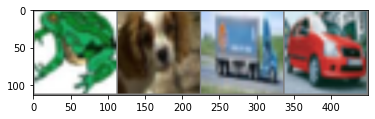

 frog   dog truck   car


In [68]:
train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=4,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    print(img.shape)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



In [48]:
#Getting DataLoaders with original batch size

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 110, 110])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([5, 5, 3, 8, 7, 2, 3, 3, 5, 7])


Let's now train a resnet model on the data


In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [42]:
import torchvision.models as models
import torch.nn as nn

# Define model
class ResNet18Cifar10Model(nn.Module):
    def __init__(self):
        super(ResNet18Cifar10Model, self).__init__()
        self.model = models.resnet18(pretrained=False)
        set_parameter_requires_grad(self.model, False)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)
        input_size = 110

    def forward(self, x):
         return self.model.forward(x)  

# def initialize_model(num_classes, feature_extract, use_pretrained=False):
#     model_ft = models.resnet18(pretrained=use_pretrained)
#     set_parameter_requires_grad(model_ft, feature_extract)
#     num_ftrs = model_ft.fc.in_features
#     model_ft.fc = nn.Linear(num_ftrs, num_classes)
#     input_size = 110
#     return model_ft, input_size

# Initialize the model
model_ft = ResNet18Cifar10Model()

# Print the model we just instantiated
print(model_ft)

ResNet18Cifar10Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.to(DEVICE)
                # labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
import torch.optim as optim

# Send the model to GPU
# model_ft = model_ft.to(DEVICE)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
feature_extract=False
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 model.conv1.weight
	 model.bn1.weight
	 model.bn1.bias
	 model.layer1.0.conv1.weight
	 model.layer1.0.bn1.weight
	 model.layer1.0.bn1.bias
	 model.layer1.0.conv2.weight
	 model.layer1.0.bn2.weight
	 model.layer1.0.bn2.bias
	 model.layer1.1.conv1.weight
	 model.layer1.1.bn1.weight
	 model.layer1.1.bn1.bias
	 model.layer1.1.conv2.weight
	 model.layer1.1.bn2.weight
	 model.layer1.1.bn2.bias
	 model.layer2.0.conv1.weight
	 model.layer2.0.bn1.weight
	 model.layer2.0.bn1.bias
	 model.layer2.0.conv2.weight
	 model.layer2.0.bn2.weight
	 model.layer2.0.bn2.bias
	 model.layer2.0.downsample.0.weight
	 model.layer2.0.downsample.1.weight
	 model.layer2.0.downsample.1.bias
	 model.layer2.1.conv1.weight
	 model.layer2.1.bn1.weight
	 model.layer2.1.bn1.bias
	 model.layer2.1.conv2.weight
	 model.layer2.1.bn2.weight
	 model.layer2.1.bn2.bias
	 model.layer3.0.conv1.weight
	 model.layer3.0.bn1.weight
	 model.layer3.0.bn1.bias
	 model.layer3.0.conv2.weight
	 model.layer3.0.bn2.weight
	 m

In [ ]:
import time
import copy
#Create data dictionary
dataloaders_dict = {'train': train_loader, 'val': valid_loader}

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=10, is_inception=False)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 1.7700 Acc: 0.2423
val Loss: 0.1726 Acc: 0.0361

Epoch 1/9
----------
train Loss: 1.4627 Acc: 0.3562
val Loss: 0.1551 Acc: 0.0422

Epoch 2/9
----------
train Loss: 1.3330 Acc: 0.4061
val Loss: 0.1556 Acc: 0.0445

Epoch 3/9
----------
train Loss: 1.2294 Acc: 0.4461
val Loss: 0.1337 Acc: 0.0507

Epoch 4/9
----------
train Loss: 1.1527 Acc: 0.4769
val Loss: 0.1282 Acc: 0.0538

Epoch 5/9
----------
train Loss: 1.0845 Acc: 0.5027
val Loss: 0.1205 Acc: 0.0568

Epoch 6/9
----------
train Loss: 1.0252 Acc: 0.5267
val Loss: 0.1300 Acc: 0.0542

Epoch 7/9
----------
train Loss: 0.9698 Acc: 0.5478
val Loss: 0.1095 Acc: 0.0601

Epoch 8/9
----------
train Loss: 0.9250 Acc: 0.5656
val Loss: 0.1049 Acc: 0.0619

Epoch 9/9
----------
train Loss: 0.8852 Acc: 0.5801
val Loss: 0.1013 Acc: 0.0631

Training complete in 276m 12s
Best val Acc: 0.063060


Saving the model to use in the future

In [ ]:
PATH = BASE_PATH + '/ResNetCifar10Model'
torch.save(model_ft.state_dict(), PATH)

In [43]:
PATH = BASE_PATH + '/ResNetCifar10Model'
saved_model = ResNet18Cifar10Model()
saved_model.load_state_dict(torch.load(PATH))

# print the model architecture
print(saved_model)

ResNet18Cifar10Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

Plotting the filters

name:model.conv1
model.conv1
torch.Size([64, 3, 7, 7])
7


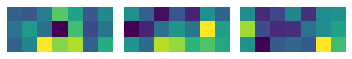

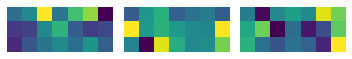

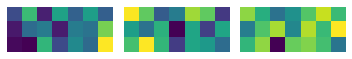

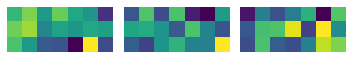

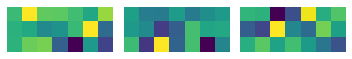

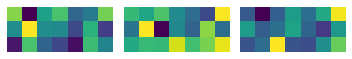

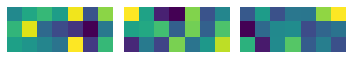

name:model.layer1.0.conv1
model.layer1.0.conv1
torch.Size([64, 64, 3, 3])
3


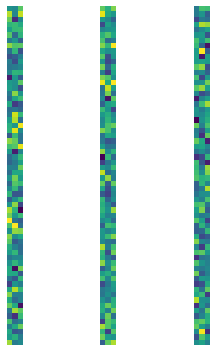

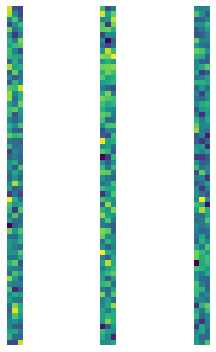

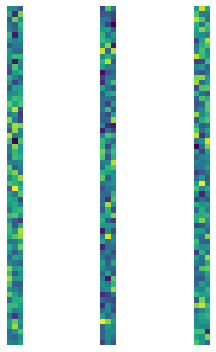

name:model.layer1.0.conv2
model.layer1.0.conv2
torch.Size([64, 64, 3, 3])
3


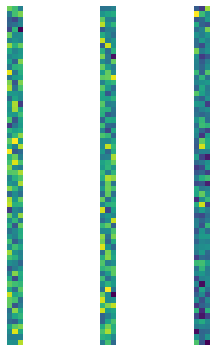

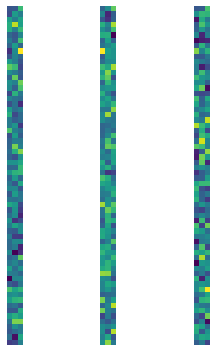

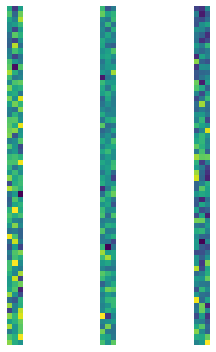

name:model.layer1.1.conv1
model.layer1.1.conv1
torch.Size([64, 64, 3, 3])
3


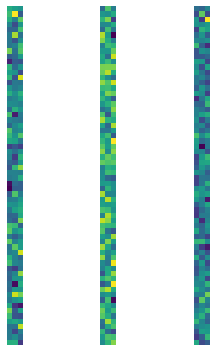

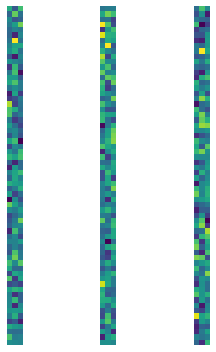

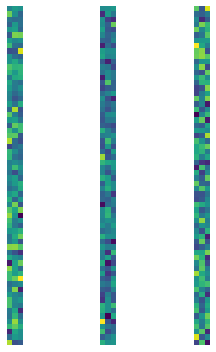

name:model.layer1.1.conv2
model.layer1.1.conv2
torch.Size([64, 64, 3, 3])
3


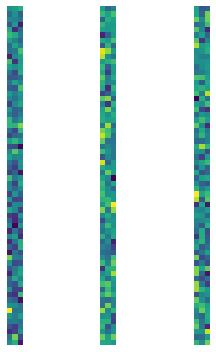

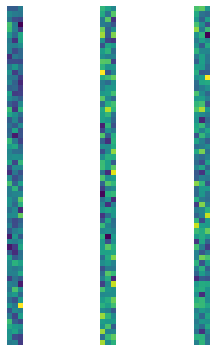

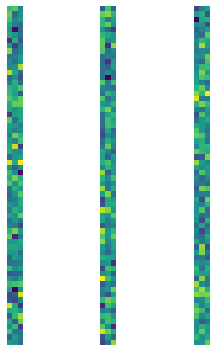

name:model.layer2.0.conv1
model.layer2.0.conv1
torch.Size([128, 64, 3, 3])
3


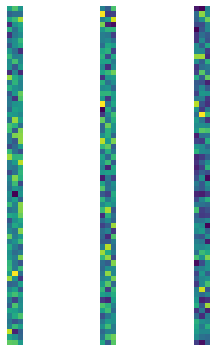

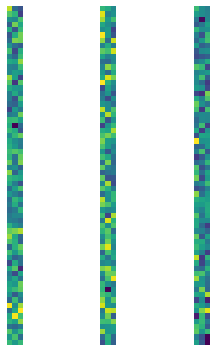

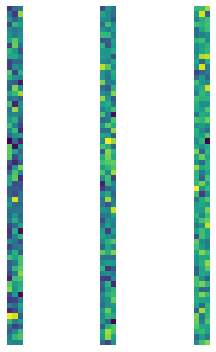

name:model.layer2.0.conv2
model.layer2.0.conv2
torch.Size([128, 128, 3, 3])
3


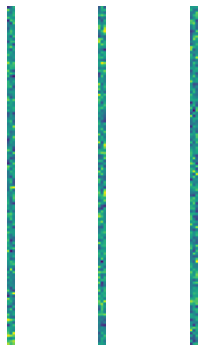

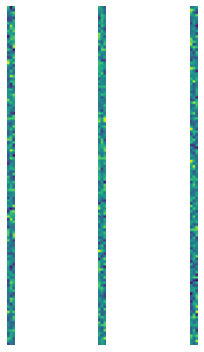

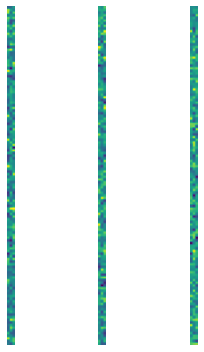

name:model.layer2.0.downsample.0
model.layer2.0.downsample.0
torch.Size([128, 64, 1, 1])
1


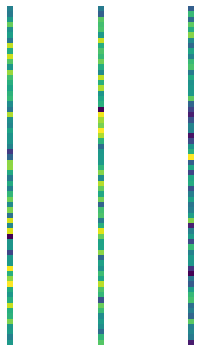

name:model.layer2.1.conv1
model.layer2.1.conv1
torch.Size([128, 128, 3, 3])
3


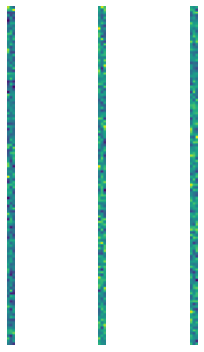

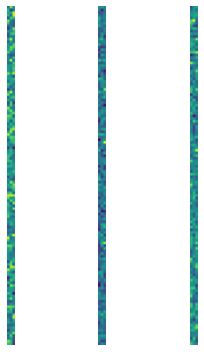

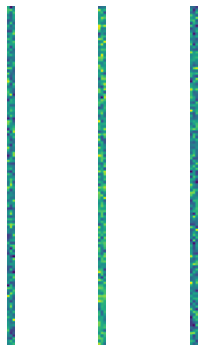

name:model.layer2.1.conv2
model.layer2.1.conv2
torch.Size([128, 128, 3, 3])
3


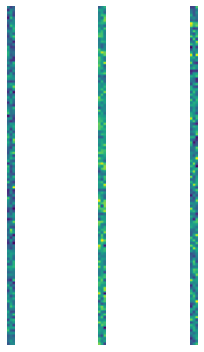

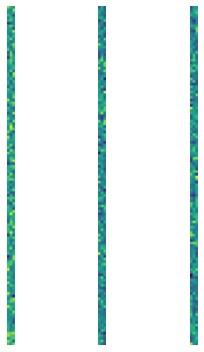

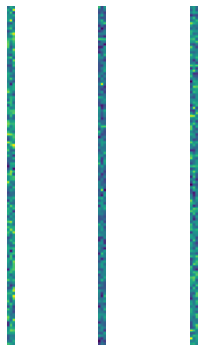

name:model.layer3.0.conv1
model.layer3.0.conv1
torch.Size([256, 128, 3, 3])
3


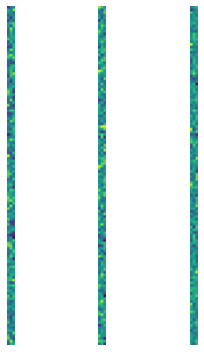

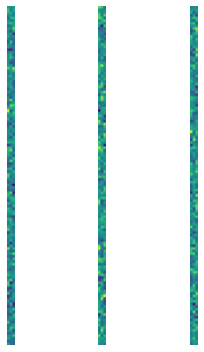

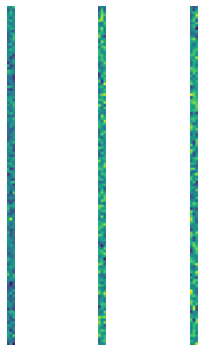

name:model.layer3.0.conv2
model.layer3.0.conv2
torch.Size([256, 256, 3, 3])
3


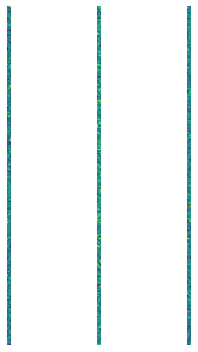

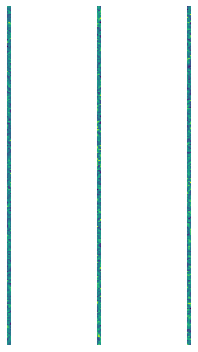

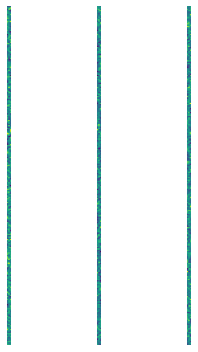

name:model.layer3.0.downsample.0
model.layer3.0.downsample.0
torch.Size([256, 128, 1, 1])
1


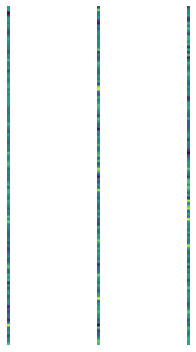

name:model.layer3.1.conv1
model.layer3.1.conv1
torch.Size([256, 256, 3, 3])
3


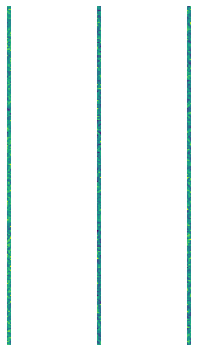

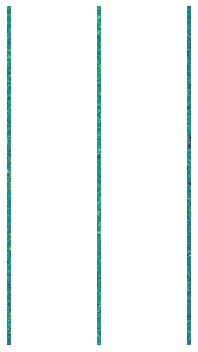

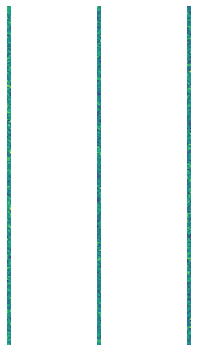

name:model.layer3.1.conv2
model.layer3.1.conv2
torch.Size([256, 256, 3, 3])
3


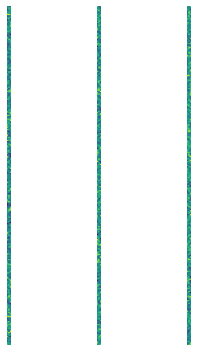

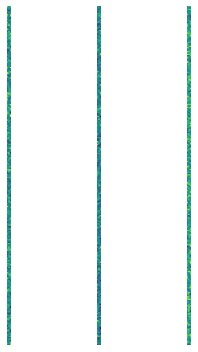

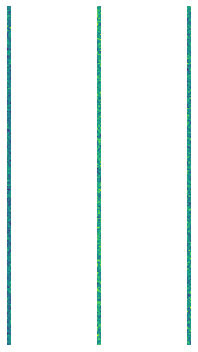

name:model.layer4.0.conv1
model.layer4.0.conv1
torch.Size([512, 256, 3, 3])
3


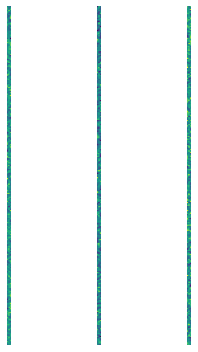

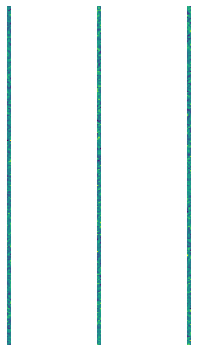

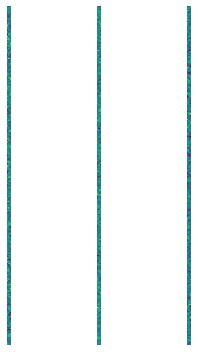

name:model.layer4.0.conv2
model.layer4.0.conv2
torch.Size([512, 512, 3, 3])
3


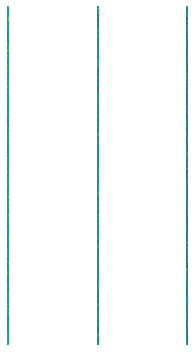

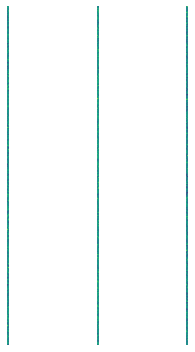

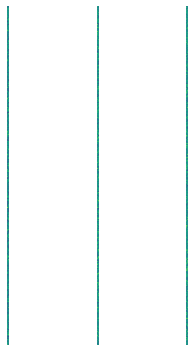

name:model.layer4.0.downsample.0
model.layer4.0.downsample.0
torch.Size([512, 256, 1, 1])
1


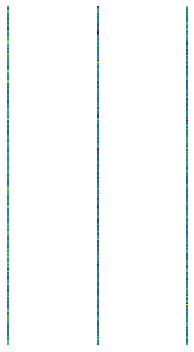

name:model.layer4.1.conv1
model.layer4.1.conv1
torch.Size([512, 512, 3, 3])
3


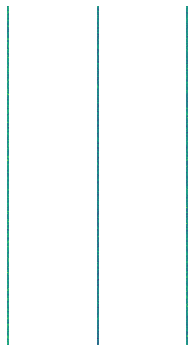

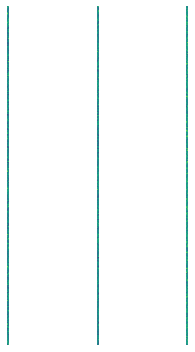

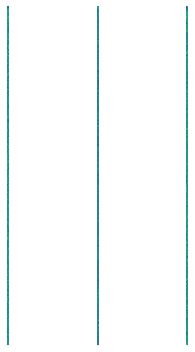

name:model.layer4.1.conv2
model.layer4.1.conv2
torch.Size([512, 512, 3, 3])
3


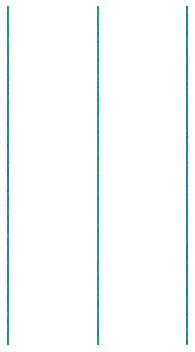

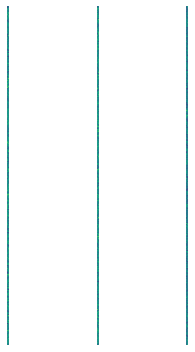

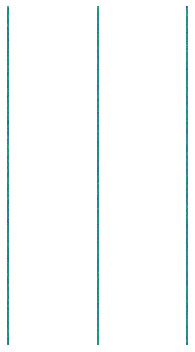

In [22]:
def plotFilters(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip( conv_filter, axes):
      with torch.no_grad():
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

#Iterate thru all the layers of the model
named_layers =  saved_model.named_modules()
for name, layer in named_layers:
    # if 'conv' in layer.name:
    if isinstance(layer, torch.nn.Conv2d):
        print('name:' + name)
        weights = layer.weight
        bias = layer.bias
        print(name)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape)
        print(filters.shape[3])
        #plotting all the filters
        for i in range(filters.shape[3]):
        #for i in range(6):
            #get the filters
            filt=filters[:,:,:, i]
            plotFilters(filt)

Plotting feature maps

torch.Size([3, 110, 110])


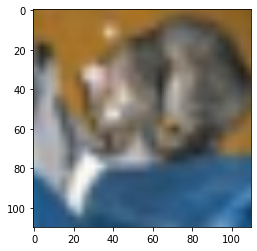

  cat


In [109]:
#getting a random sample from test dataset with label
images, labels = next(iter(test_loader))
sample_for_visuals = images[0]
imshow(torchvision.utils.make_grid(images[0]))
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [110]:
sample_for_visuals = sample_for_visuals.unsqueeze(0)

model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 17 conv layers in this list

# counter to keep count of the conv layers
counter = 0 
model_children = list(saved_model.model.children())
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")


Total convolutional layers: 17


In [ ]:
# Now let's display our representations
# Resnet is required to be put in evaluation mode in order
# to do prediction / evaluation
# saved_model.eval()
# successive_feature_maps = saved_model.model(sample_for_visuals)


In [111]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 64, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])


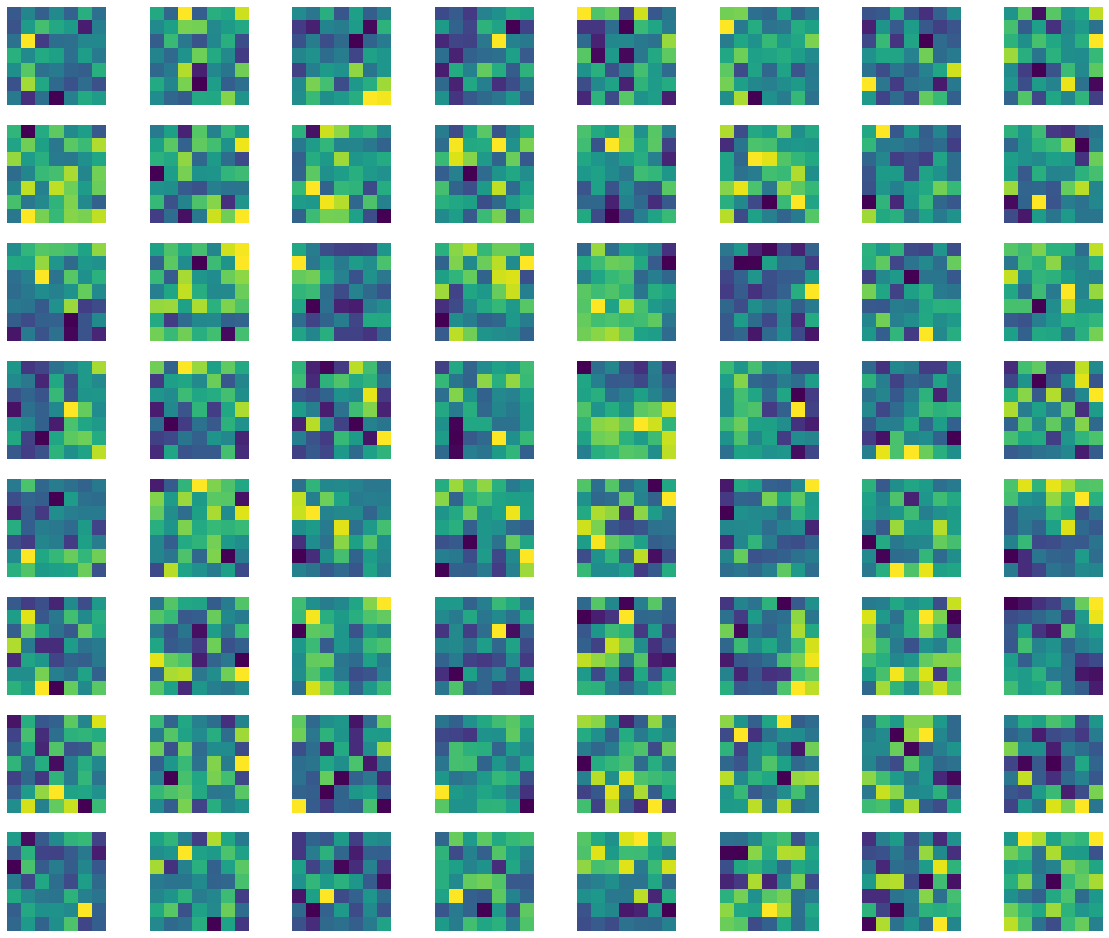

In [112]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    # plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.imshow(filter[0, :, :].detach())
    plt.axis('off')
    # plt.savefig('../outputs/filter.png')
plt.show()

In [113]:
# pass the image through all the layers
results = [conv_layers[0](sample_for_visuals)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

torch.Size([64, 55, 55])


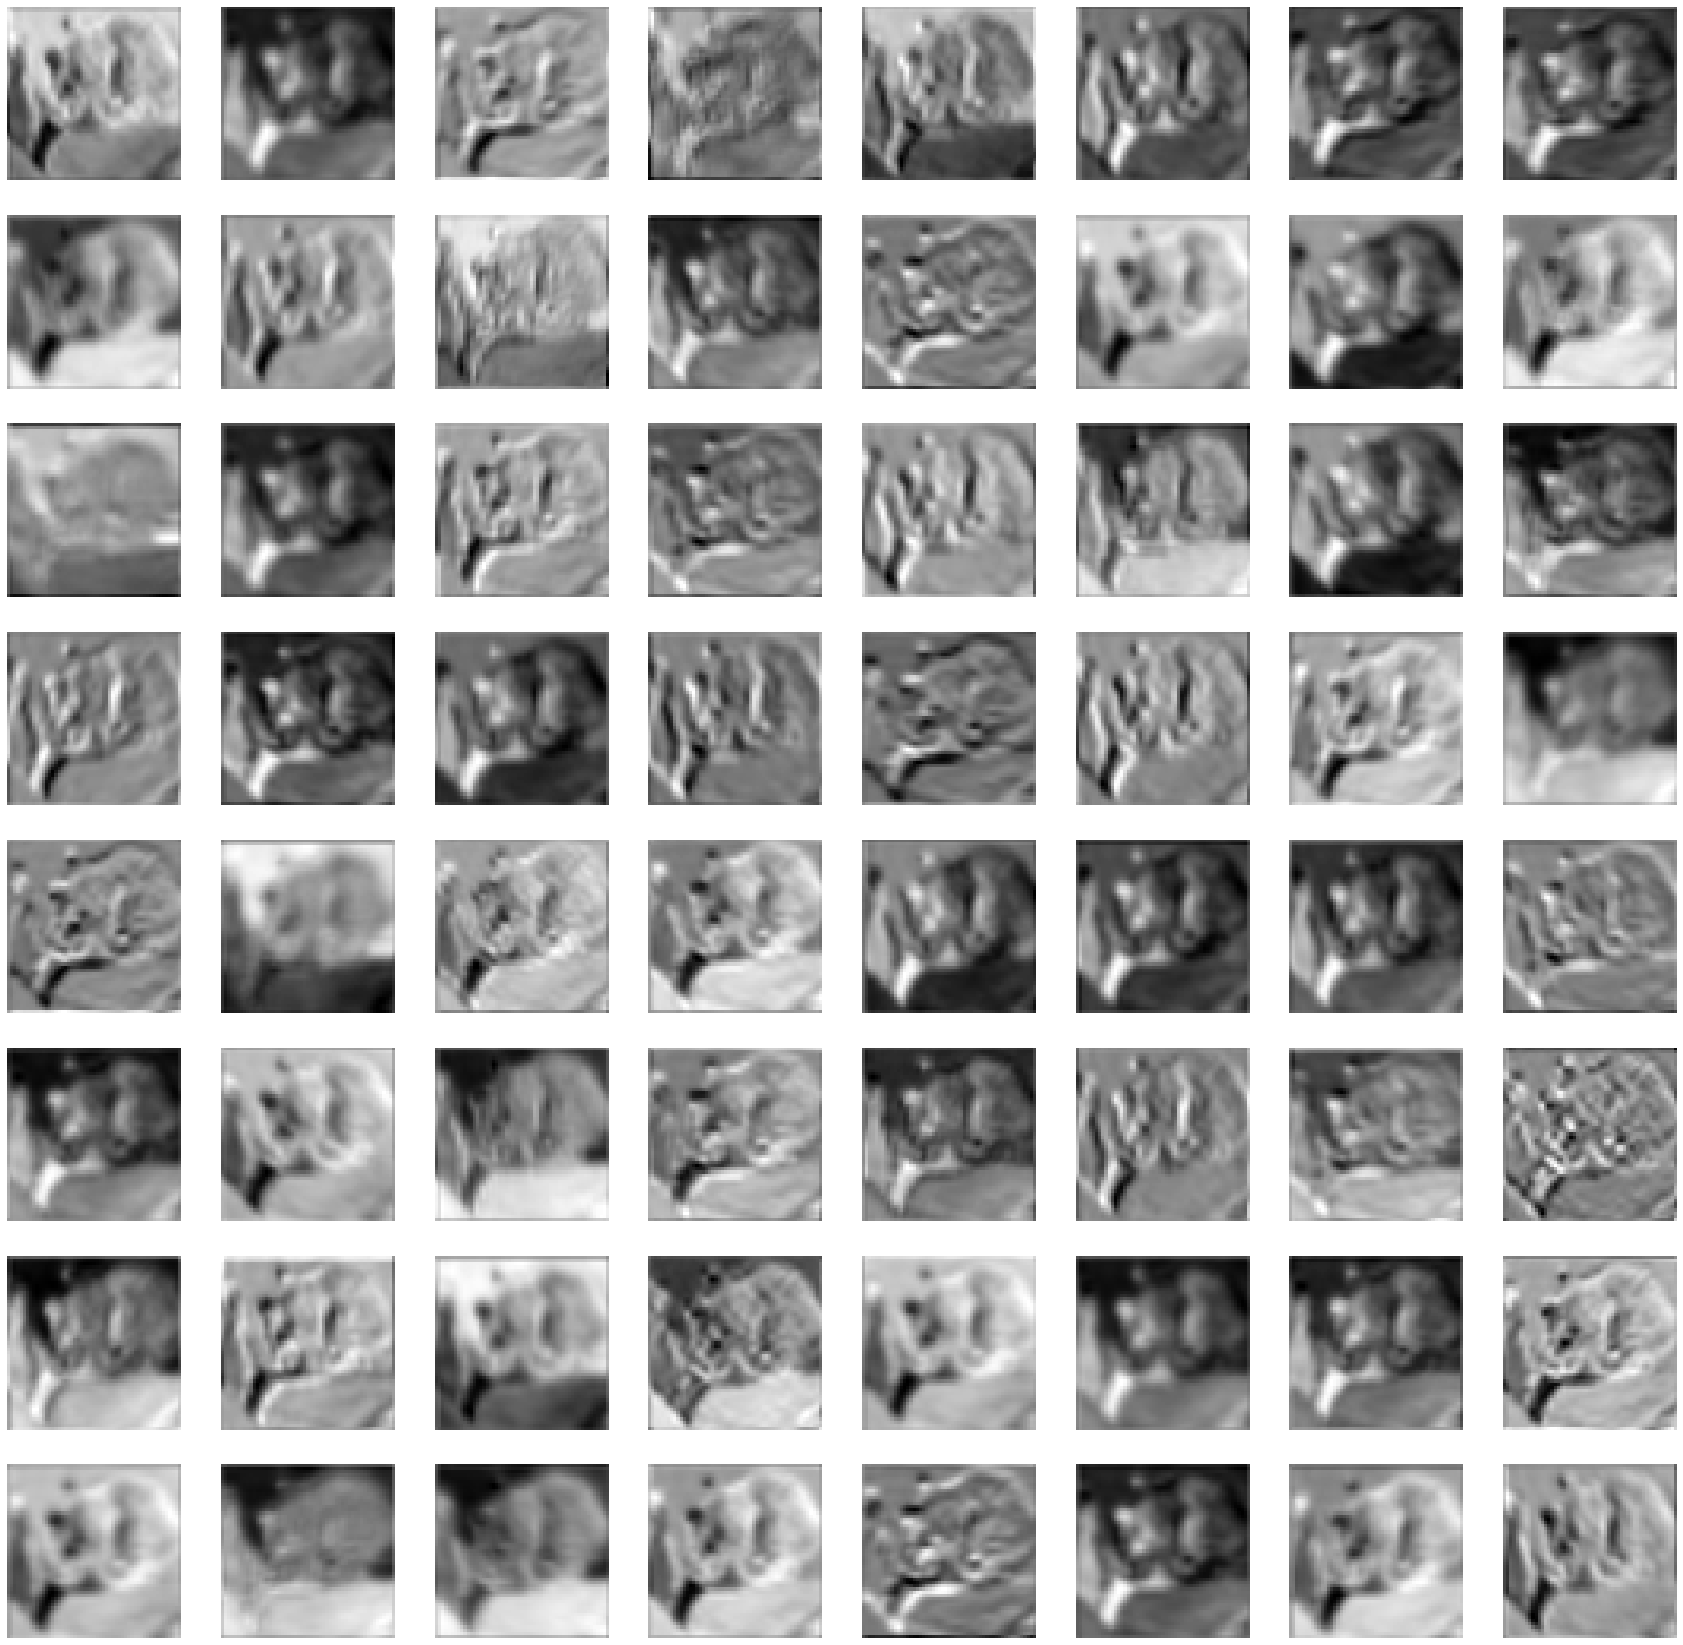

torch.Size([64, 55, 55])


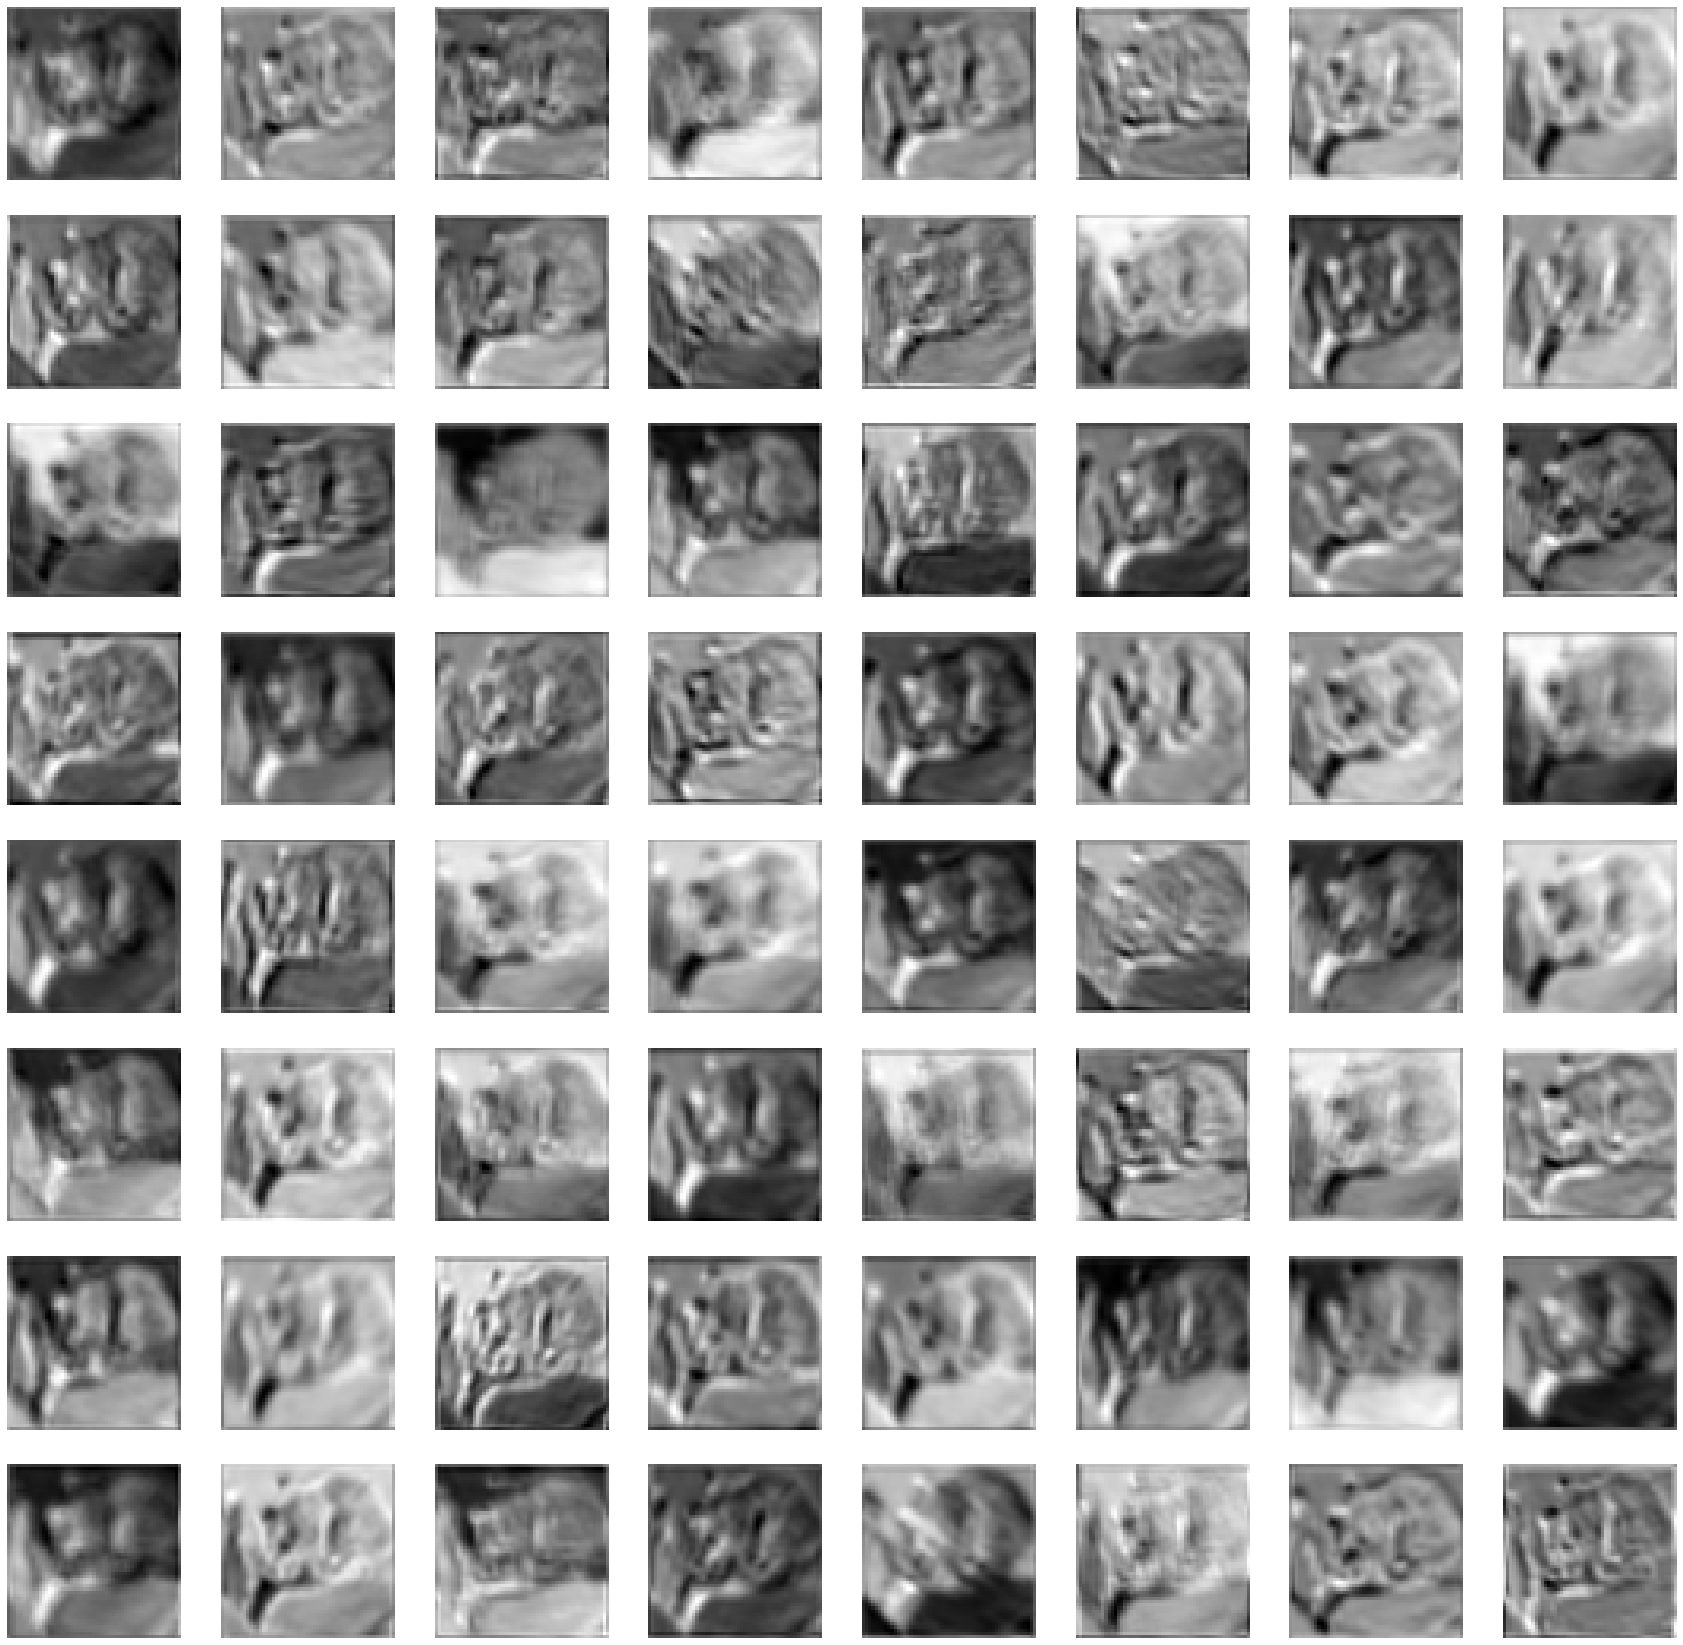

torch.Size([64, 55, 55])


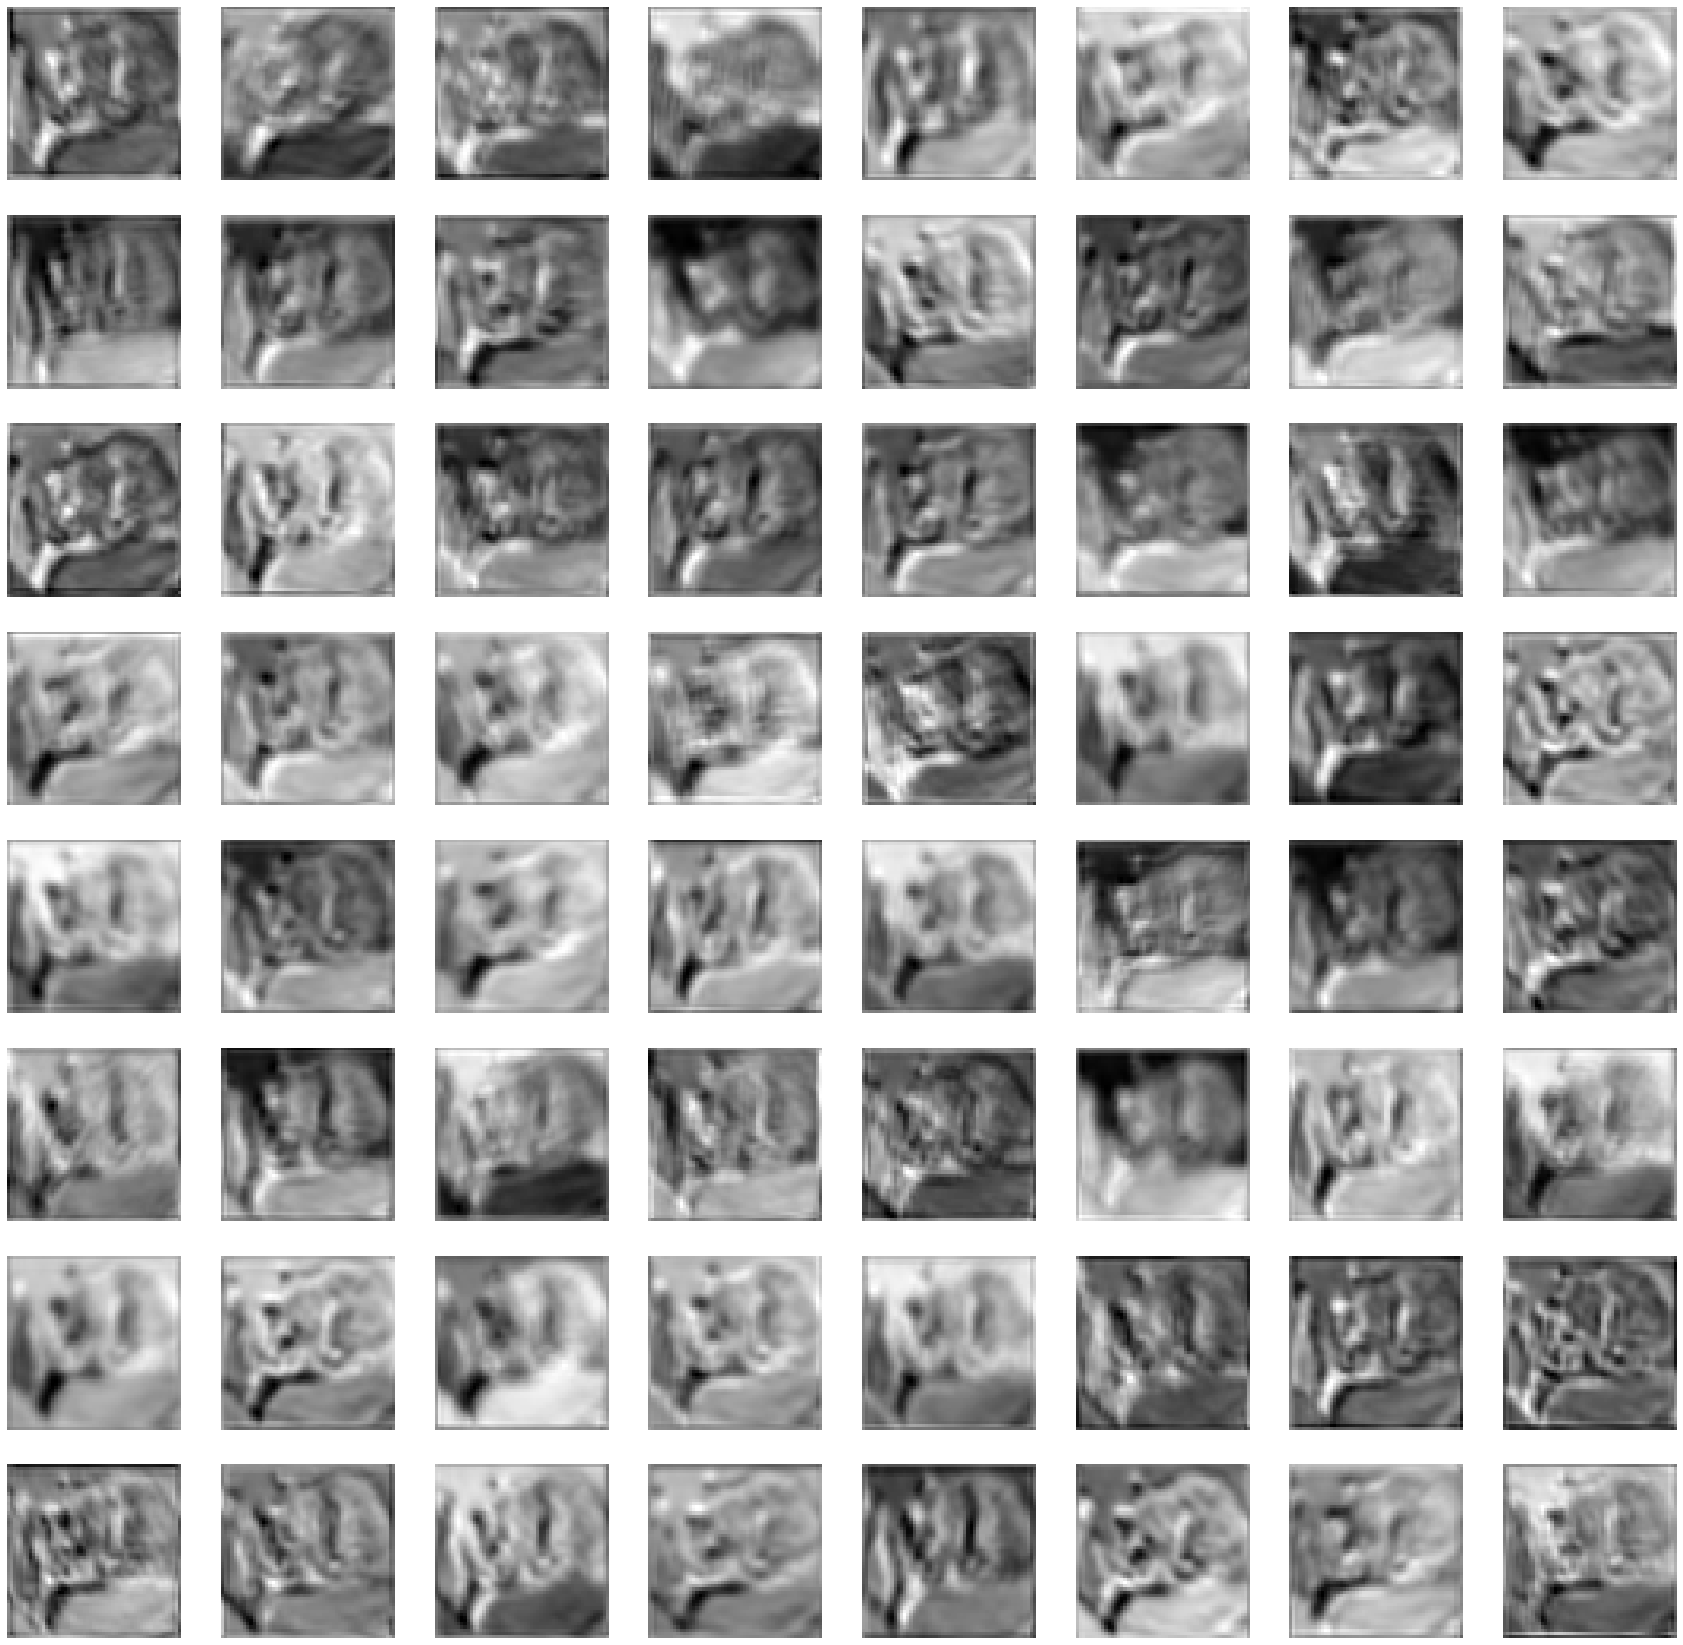

torch.Size([64, 55, 55])


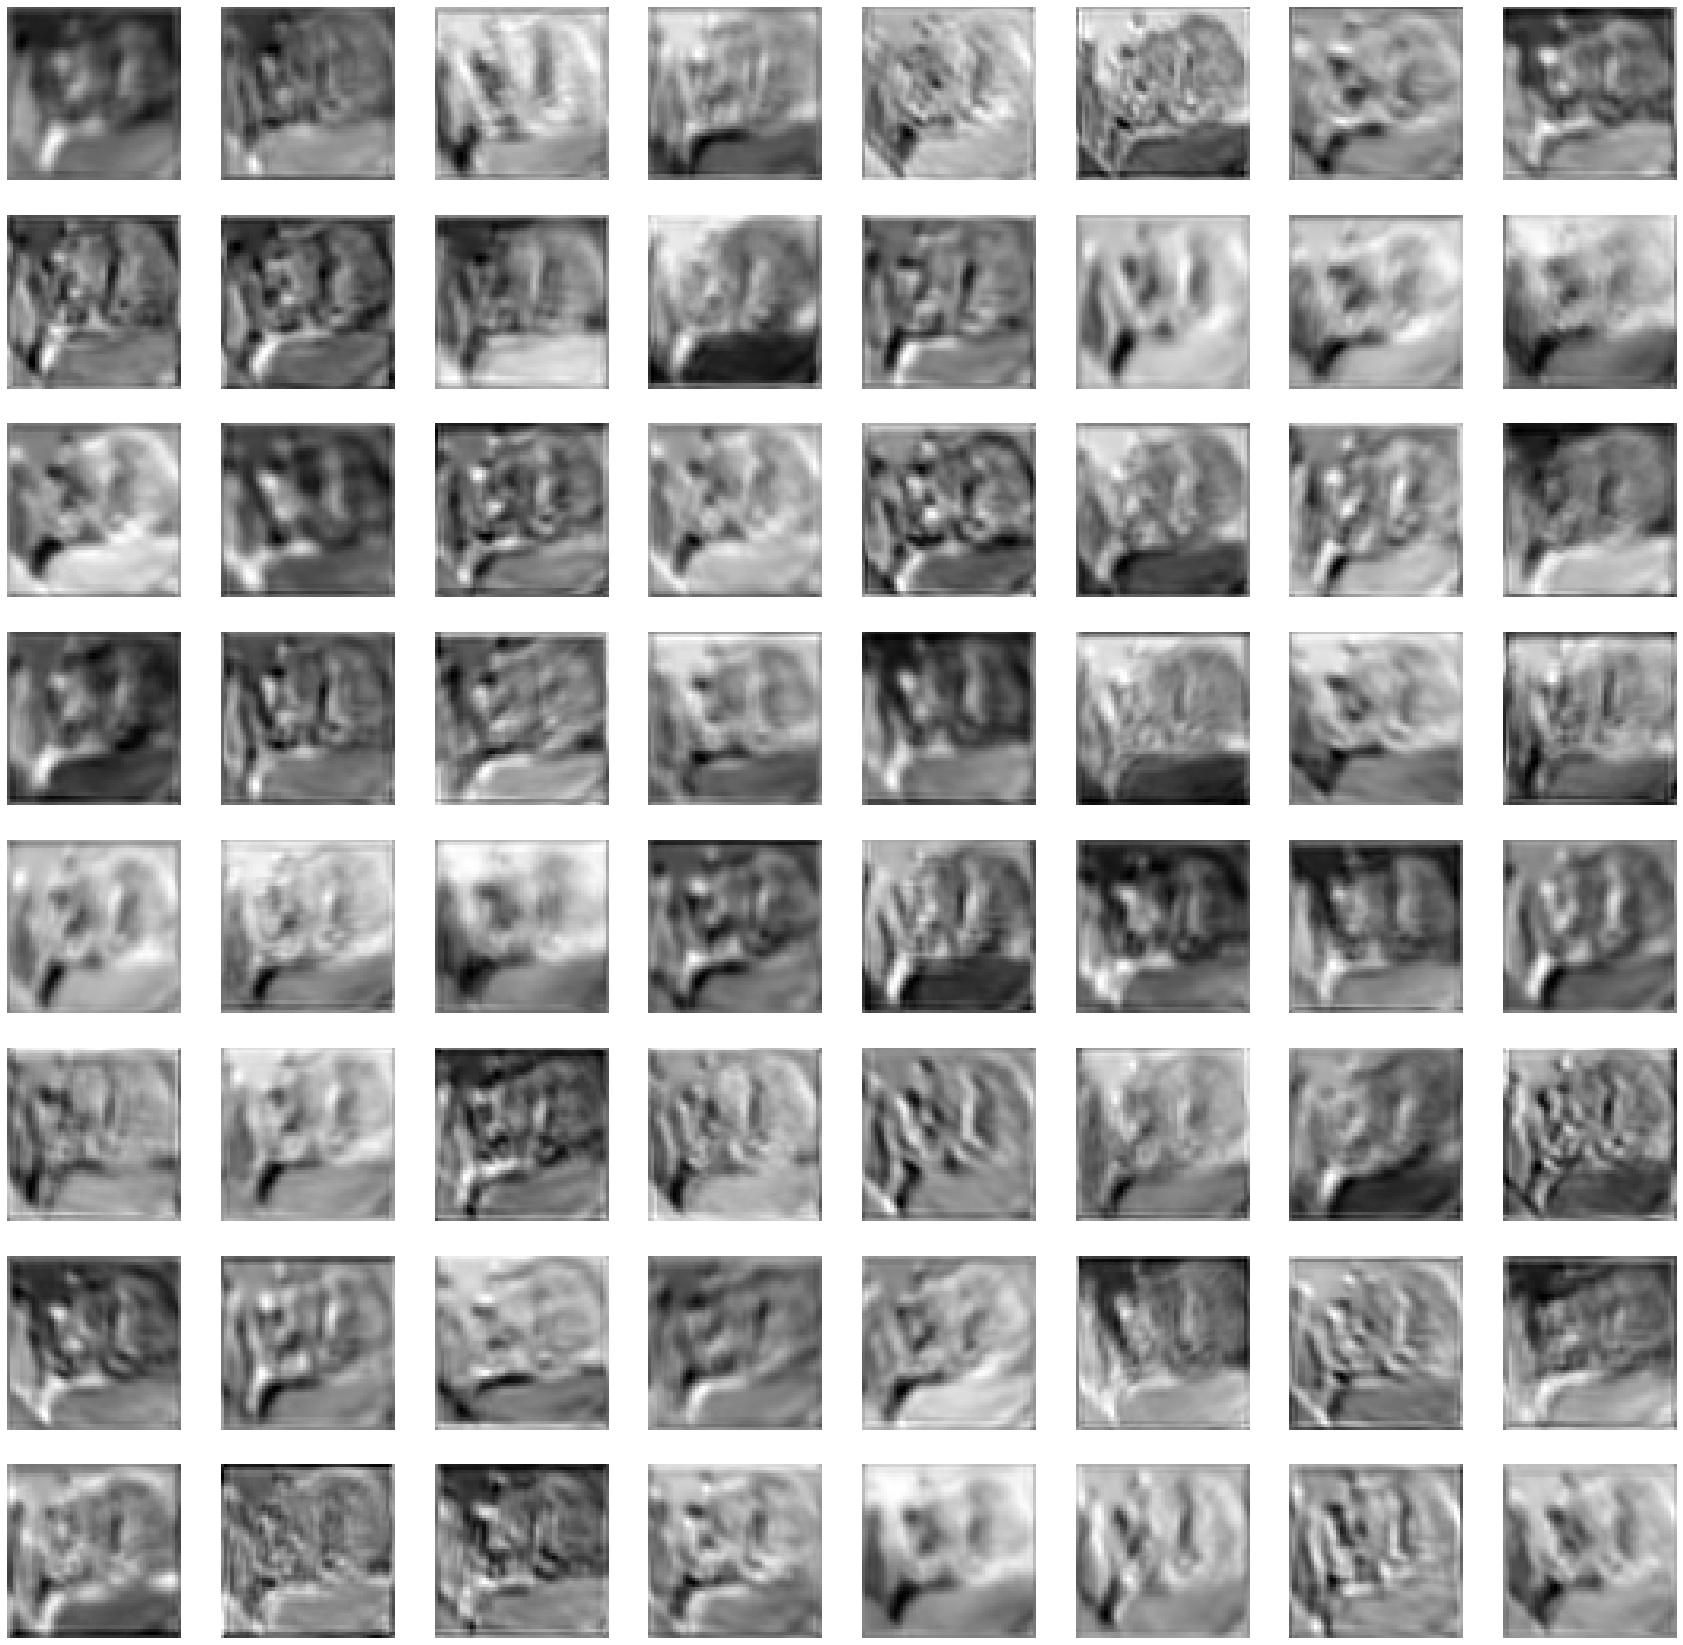

torch.Size([64, 55, 55])


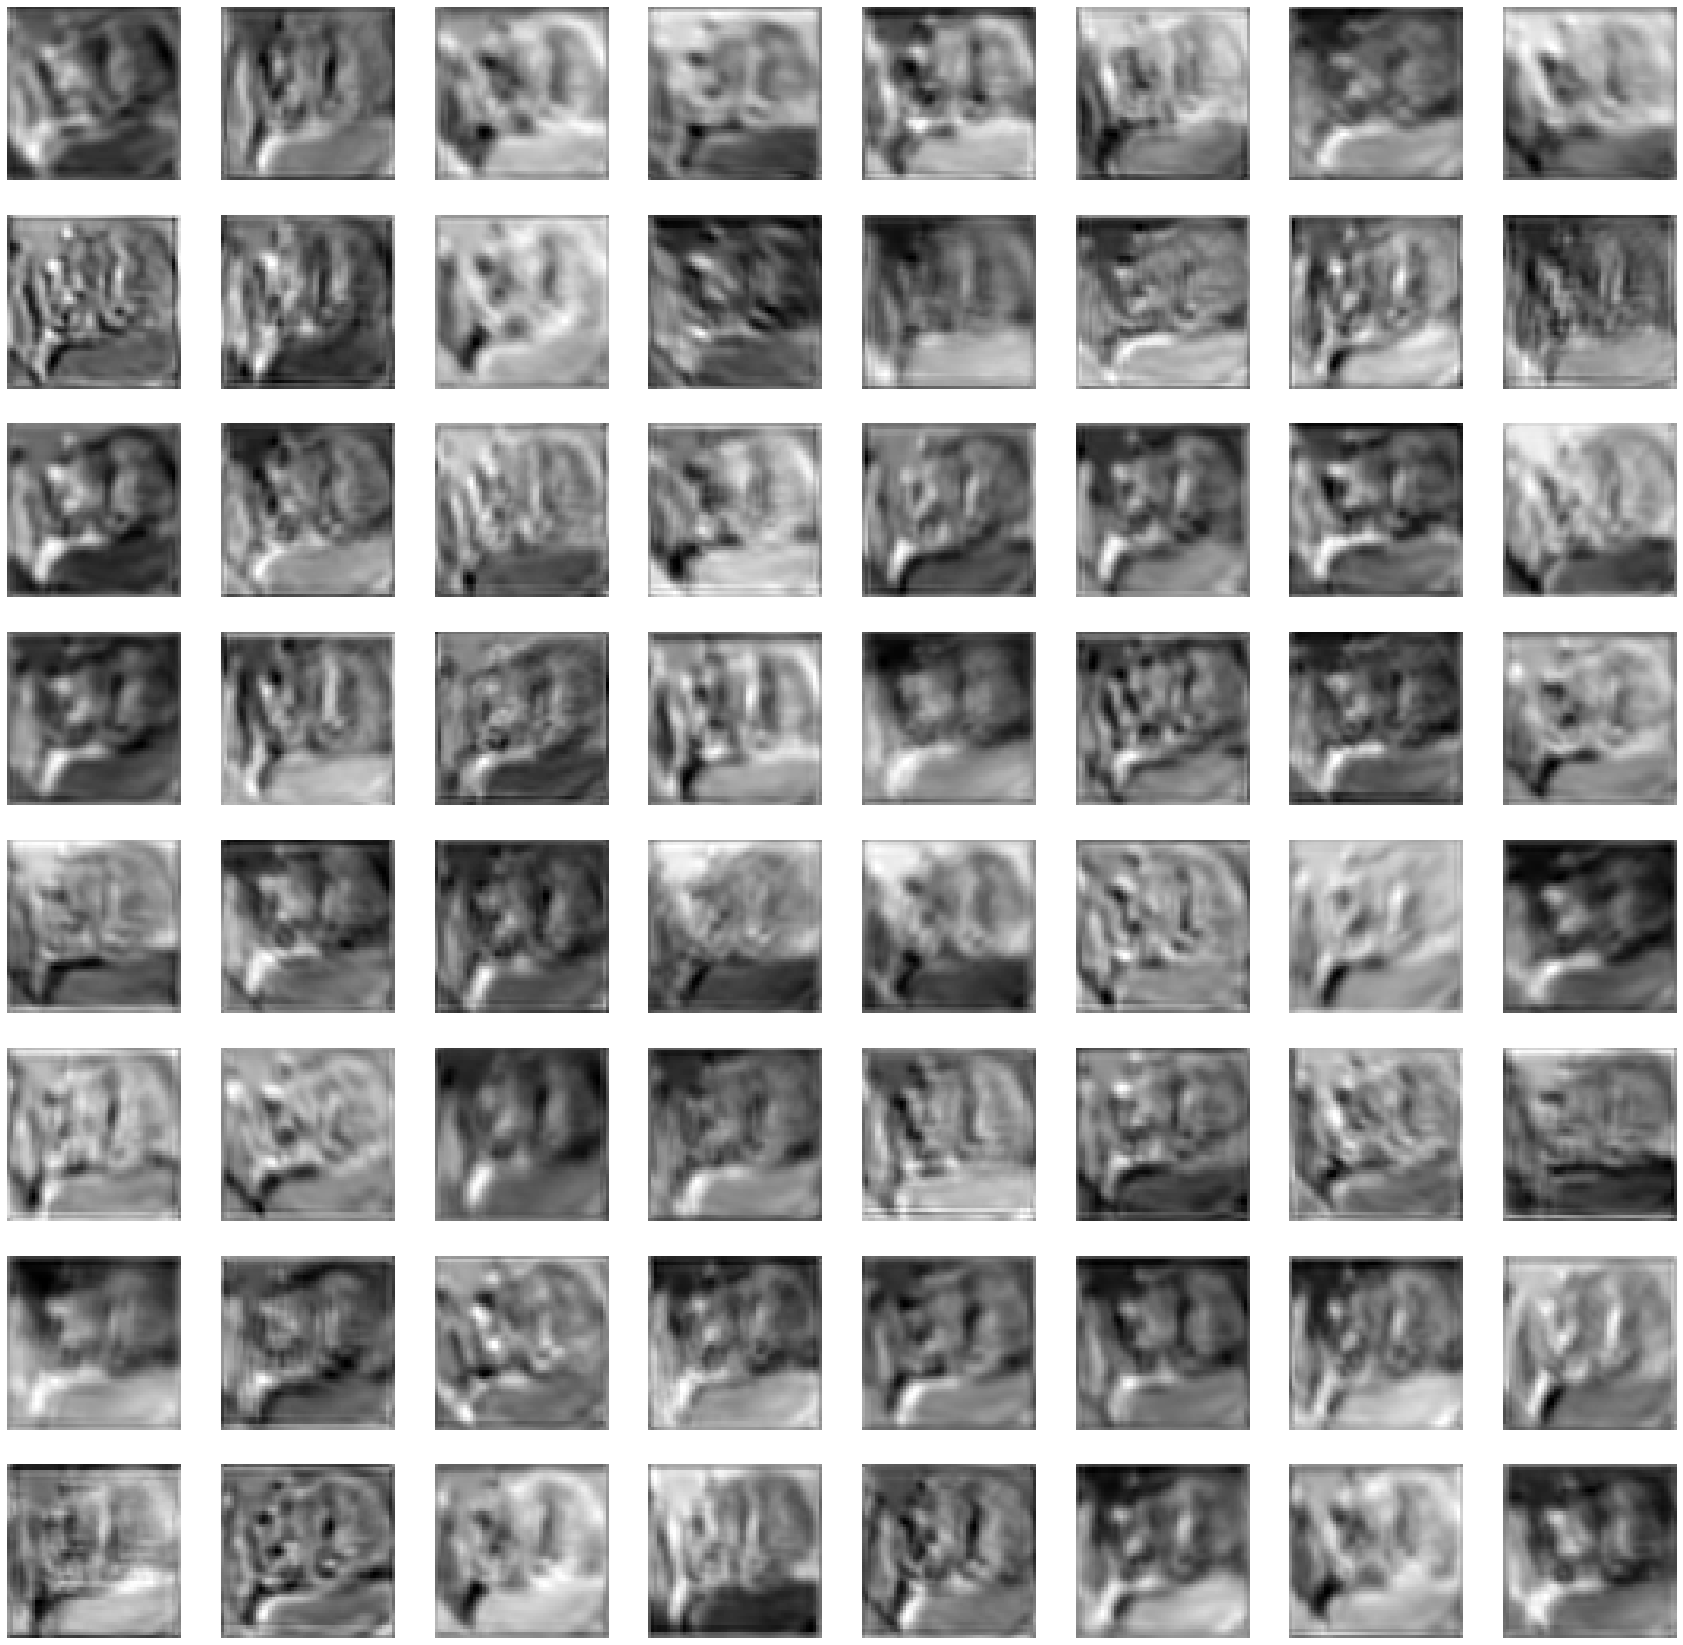

torch.Size([128, 28, 28])


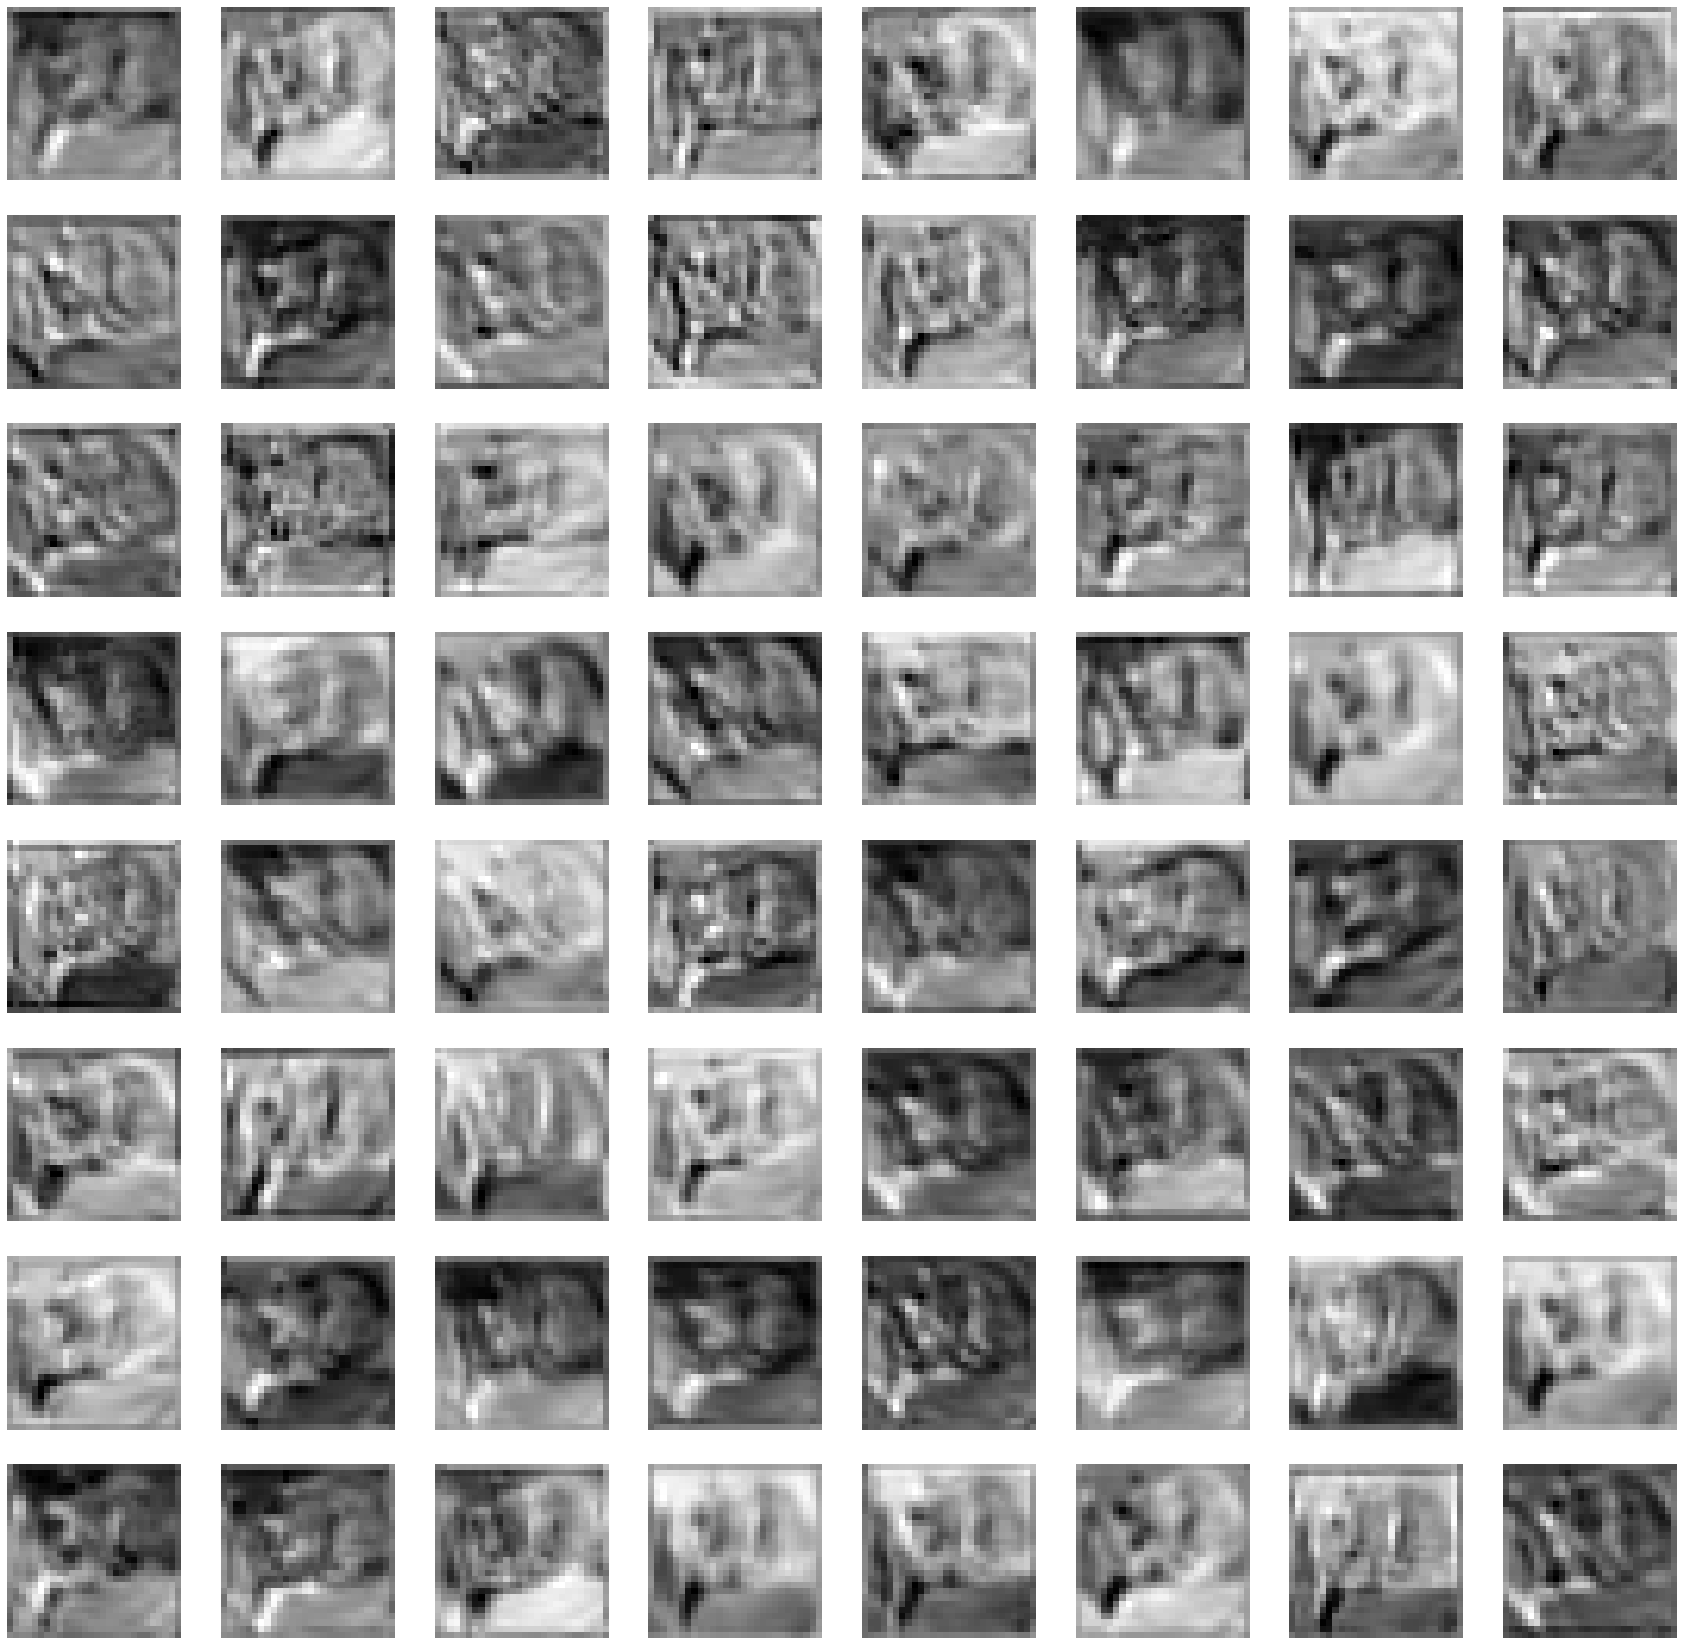

torch.Size([128, 28, 28])


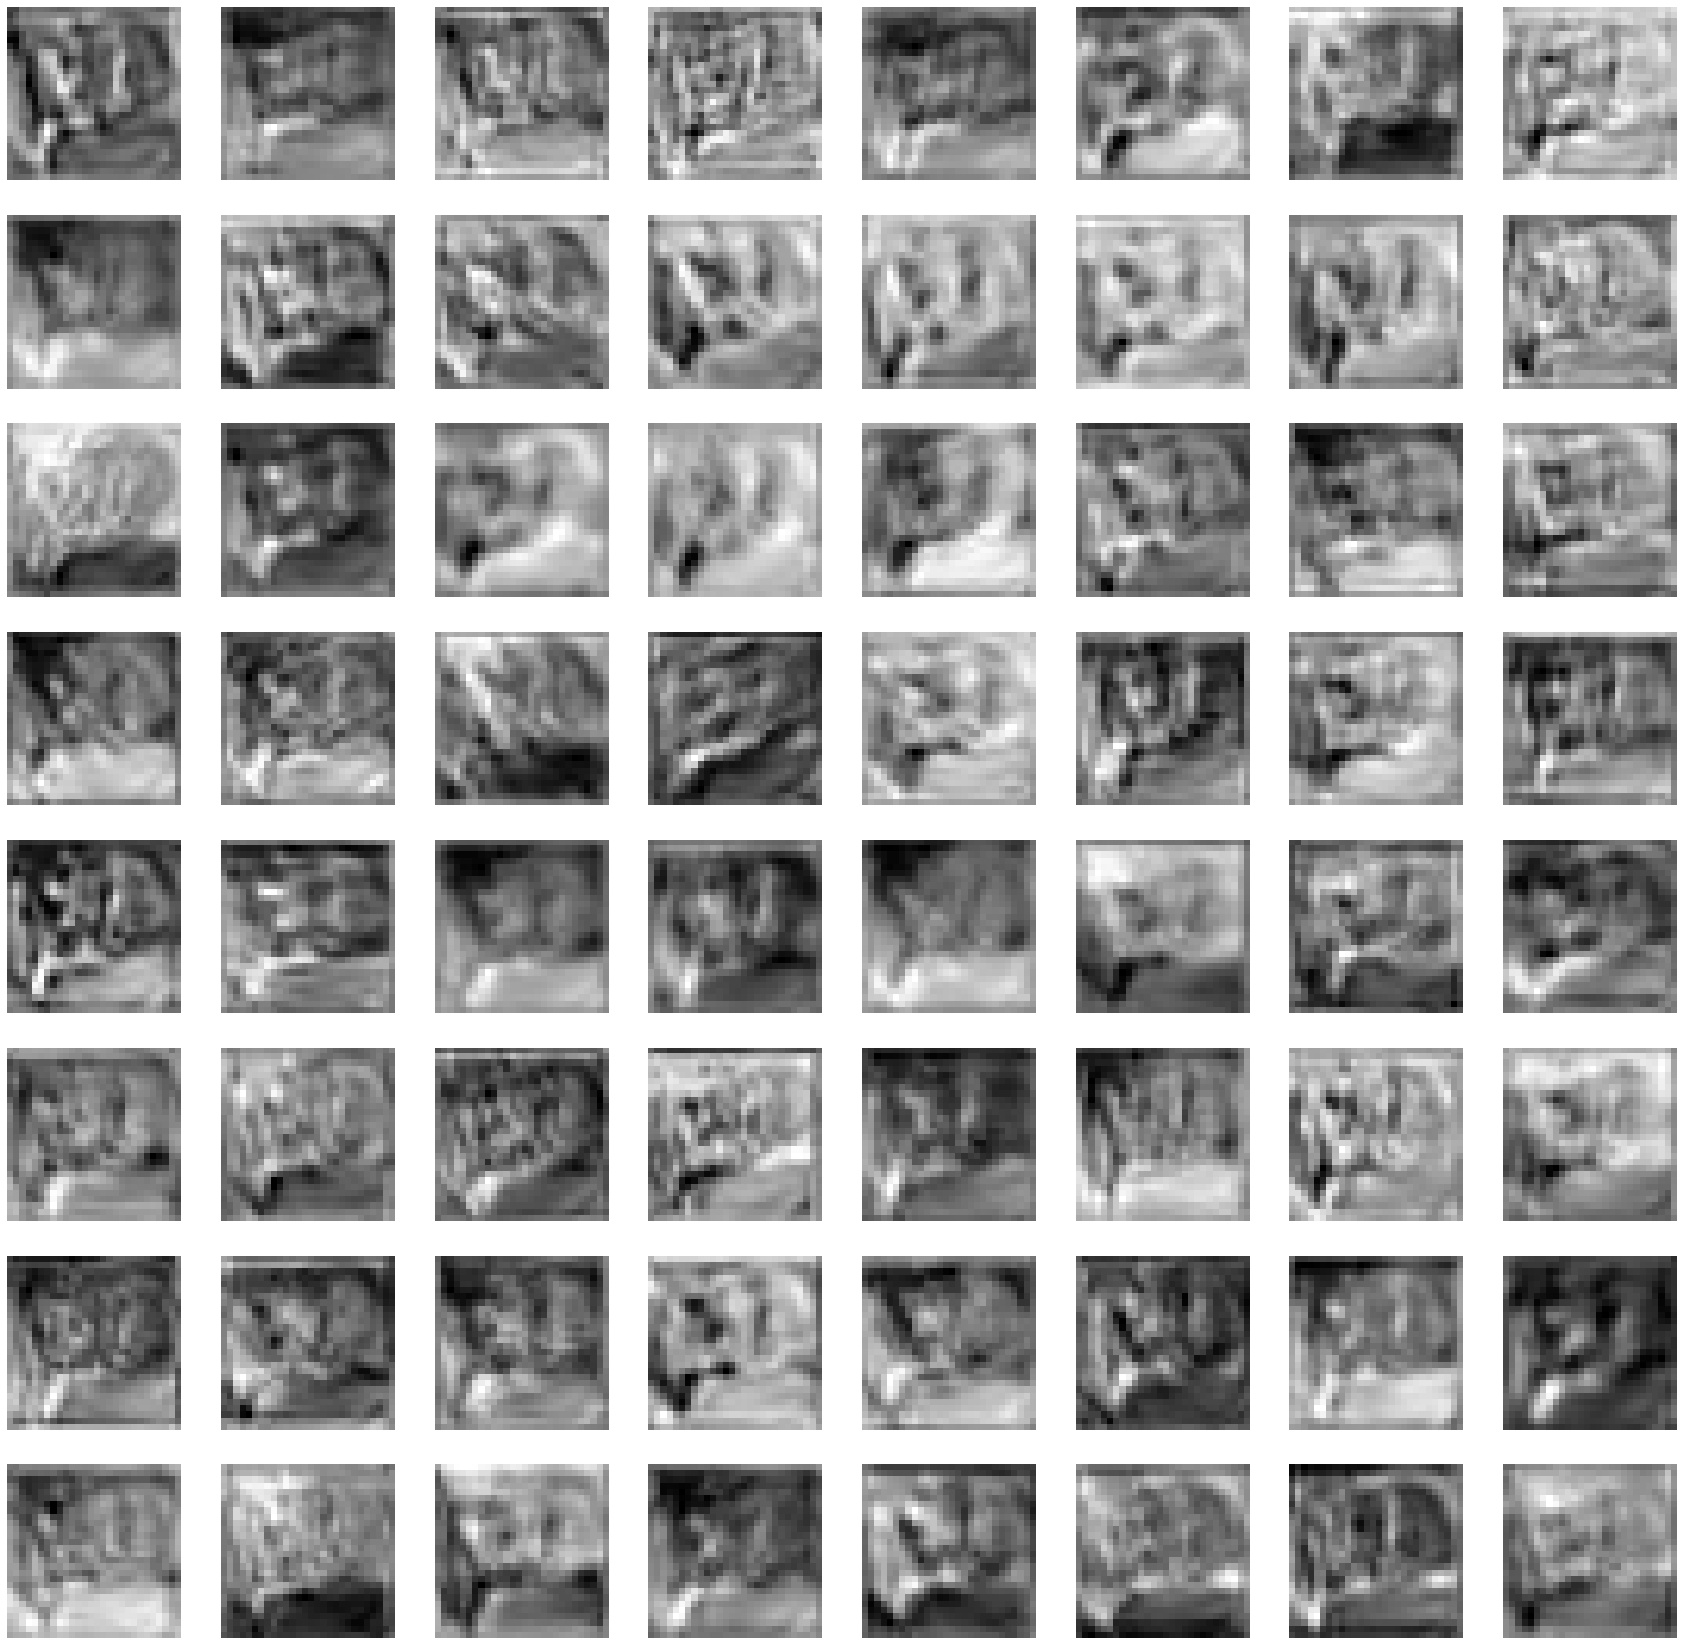

torch.Size([128, 28, 28])


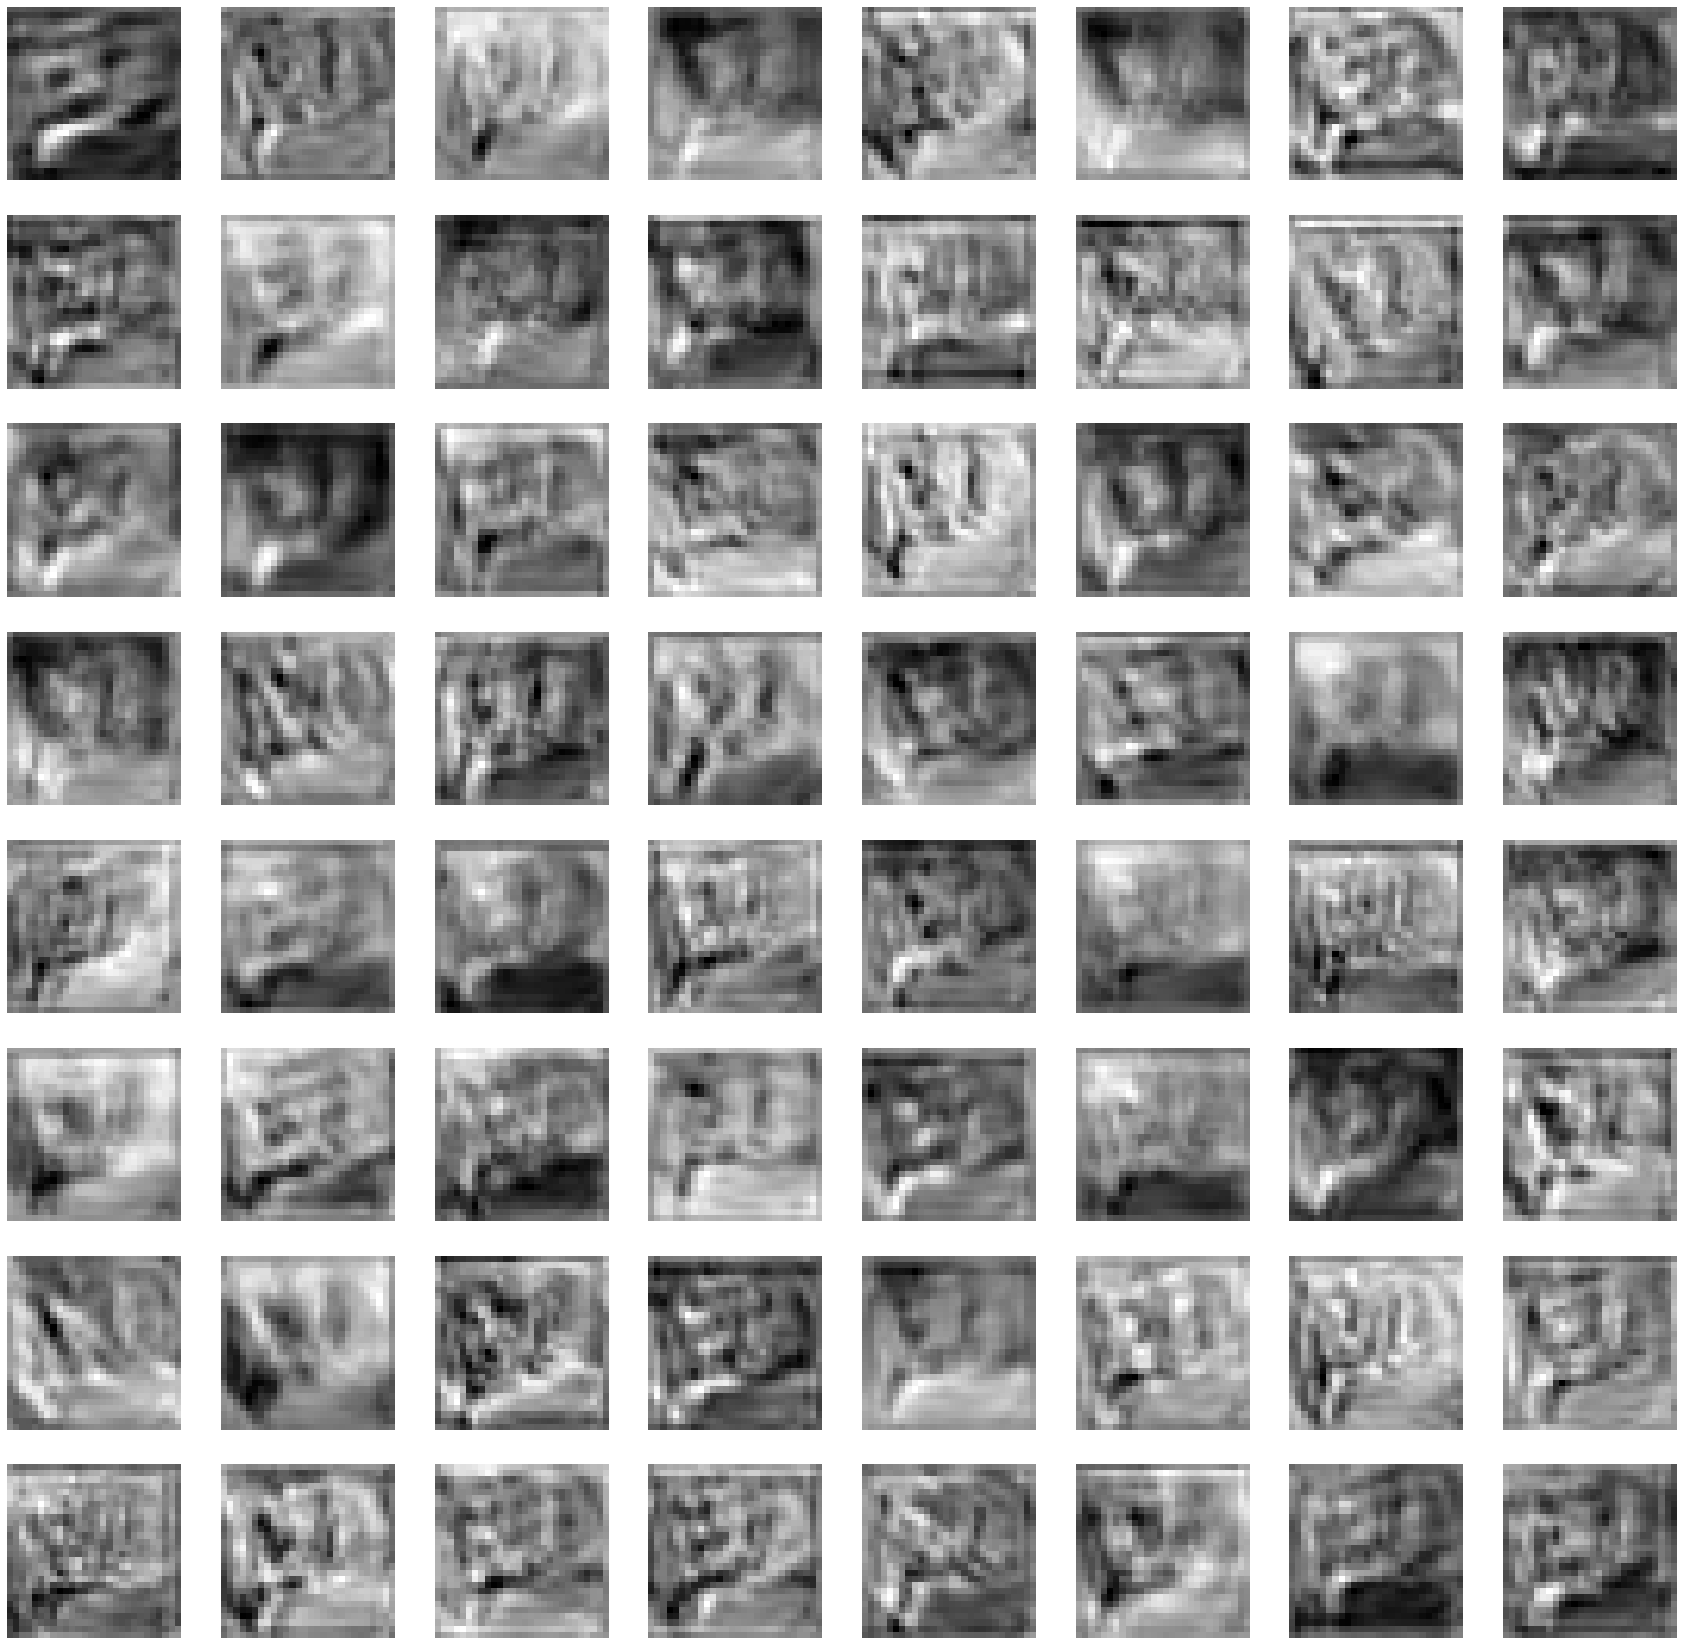

torch.Size([128, 28, 28])


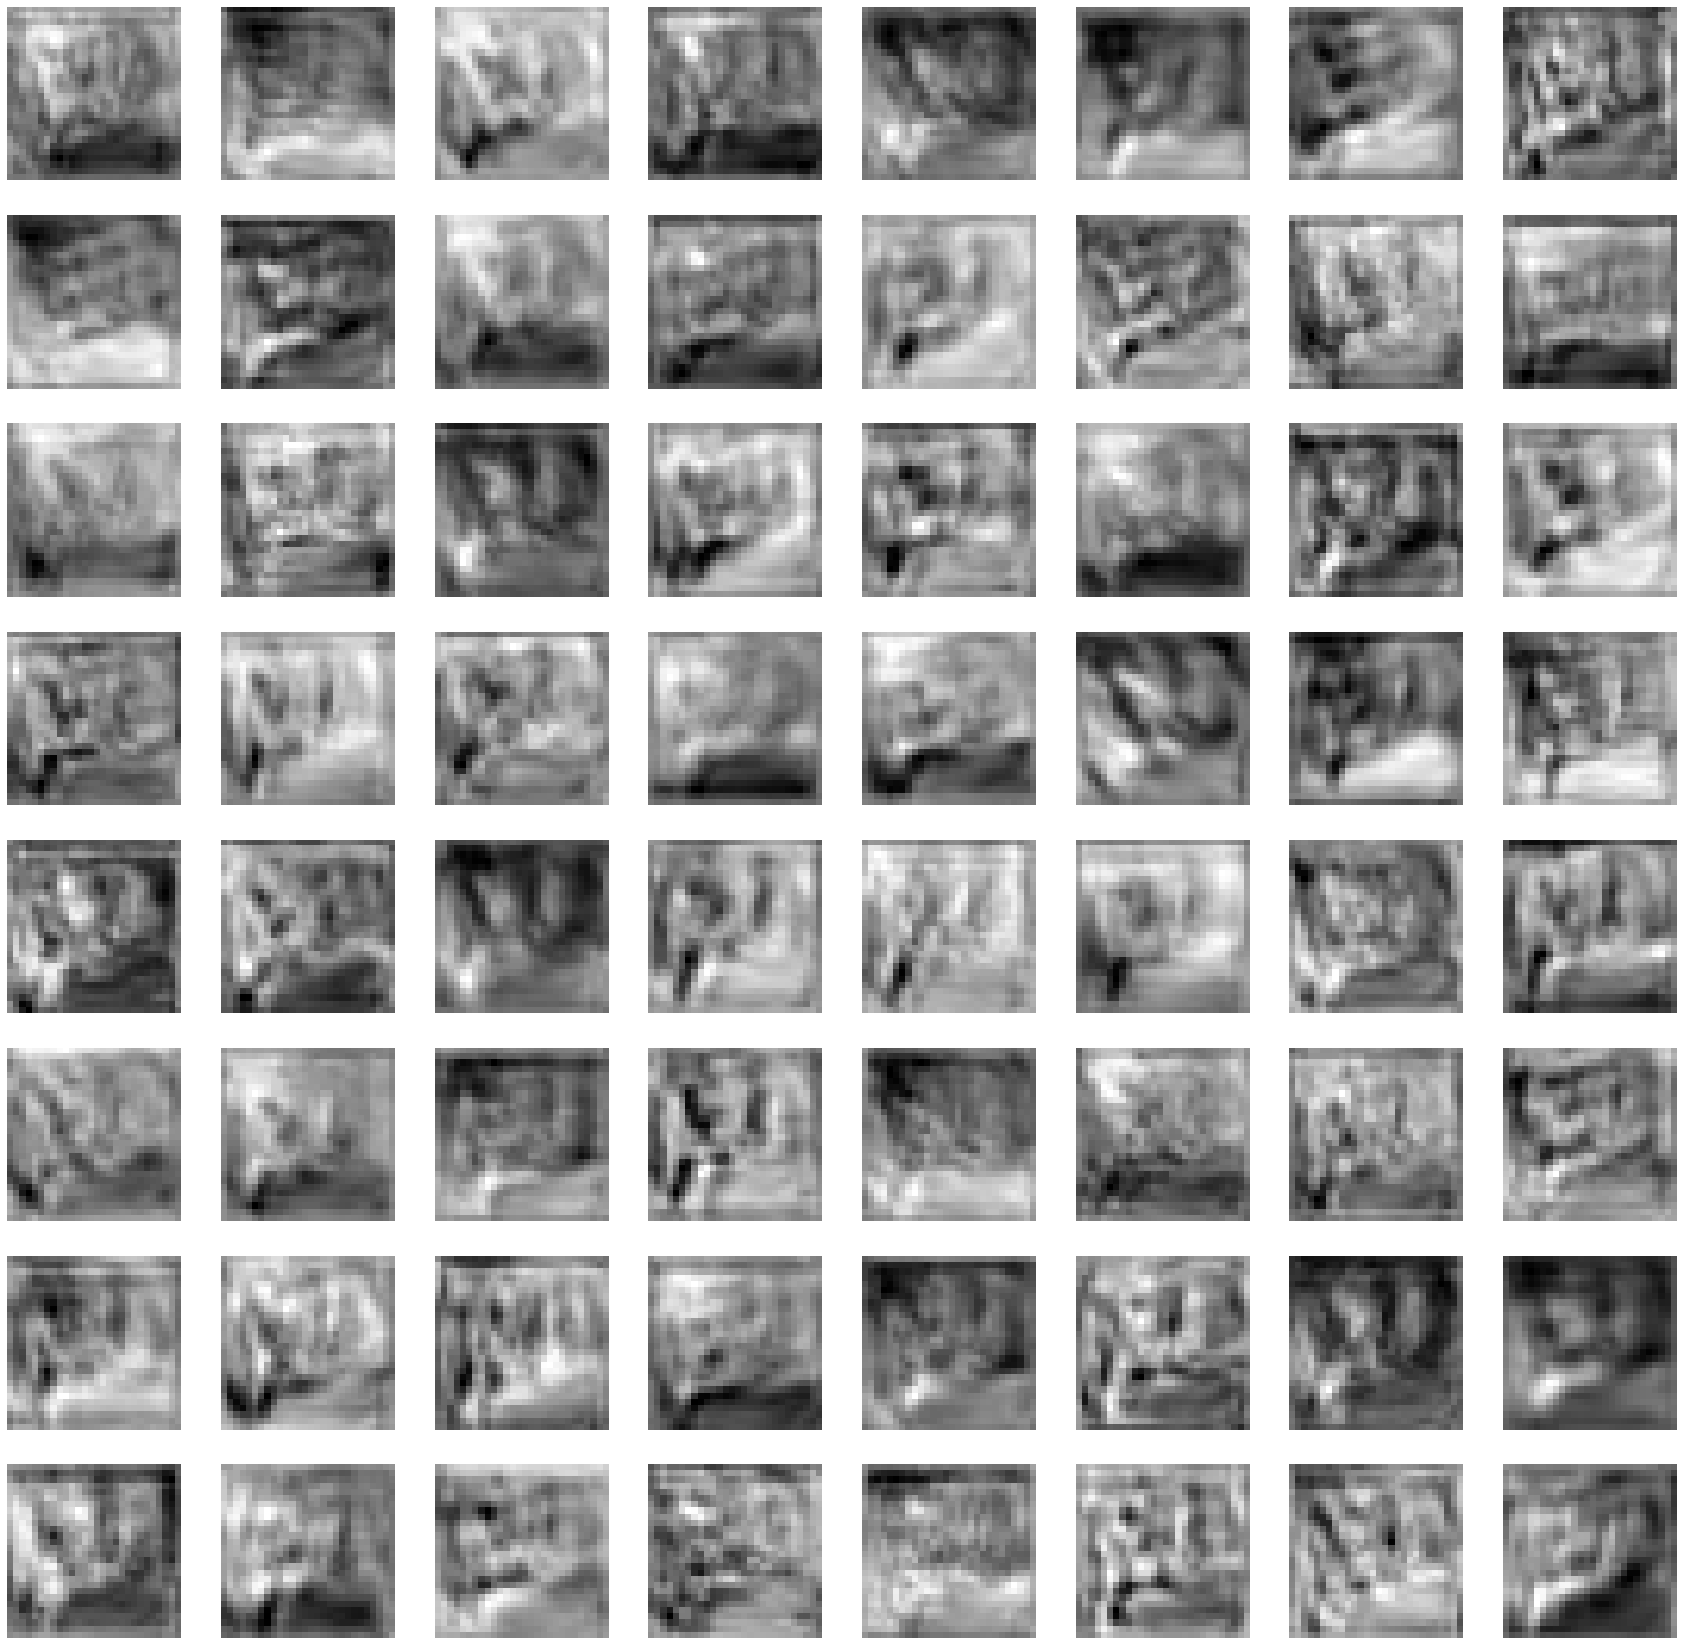

torch.Size([256, 14, 14])


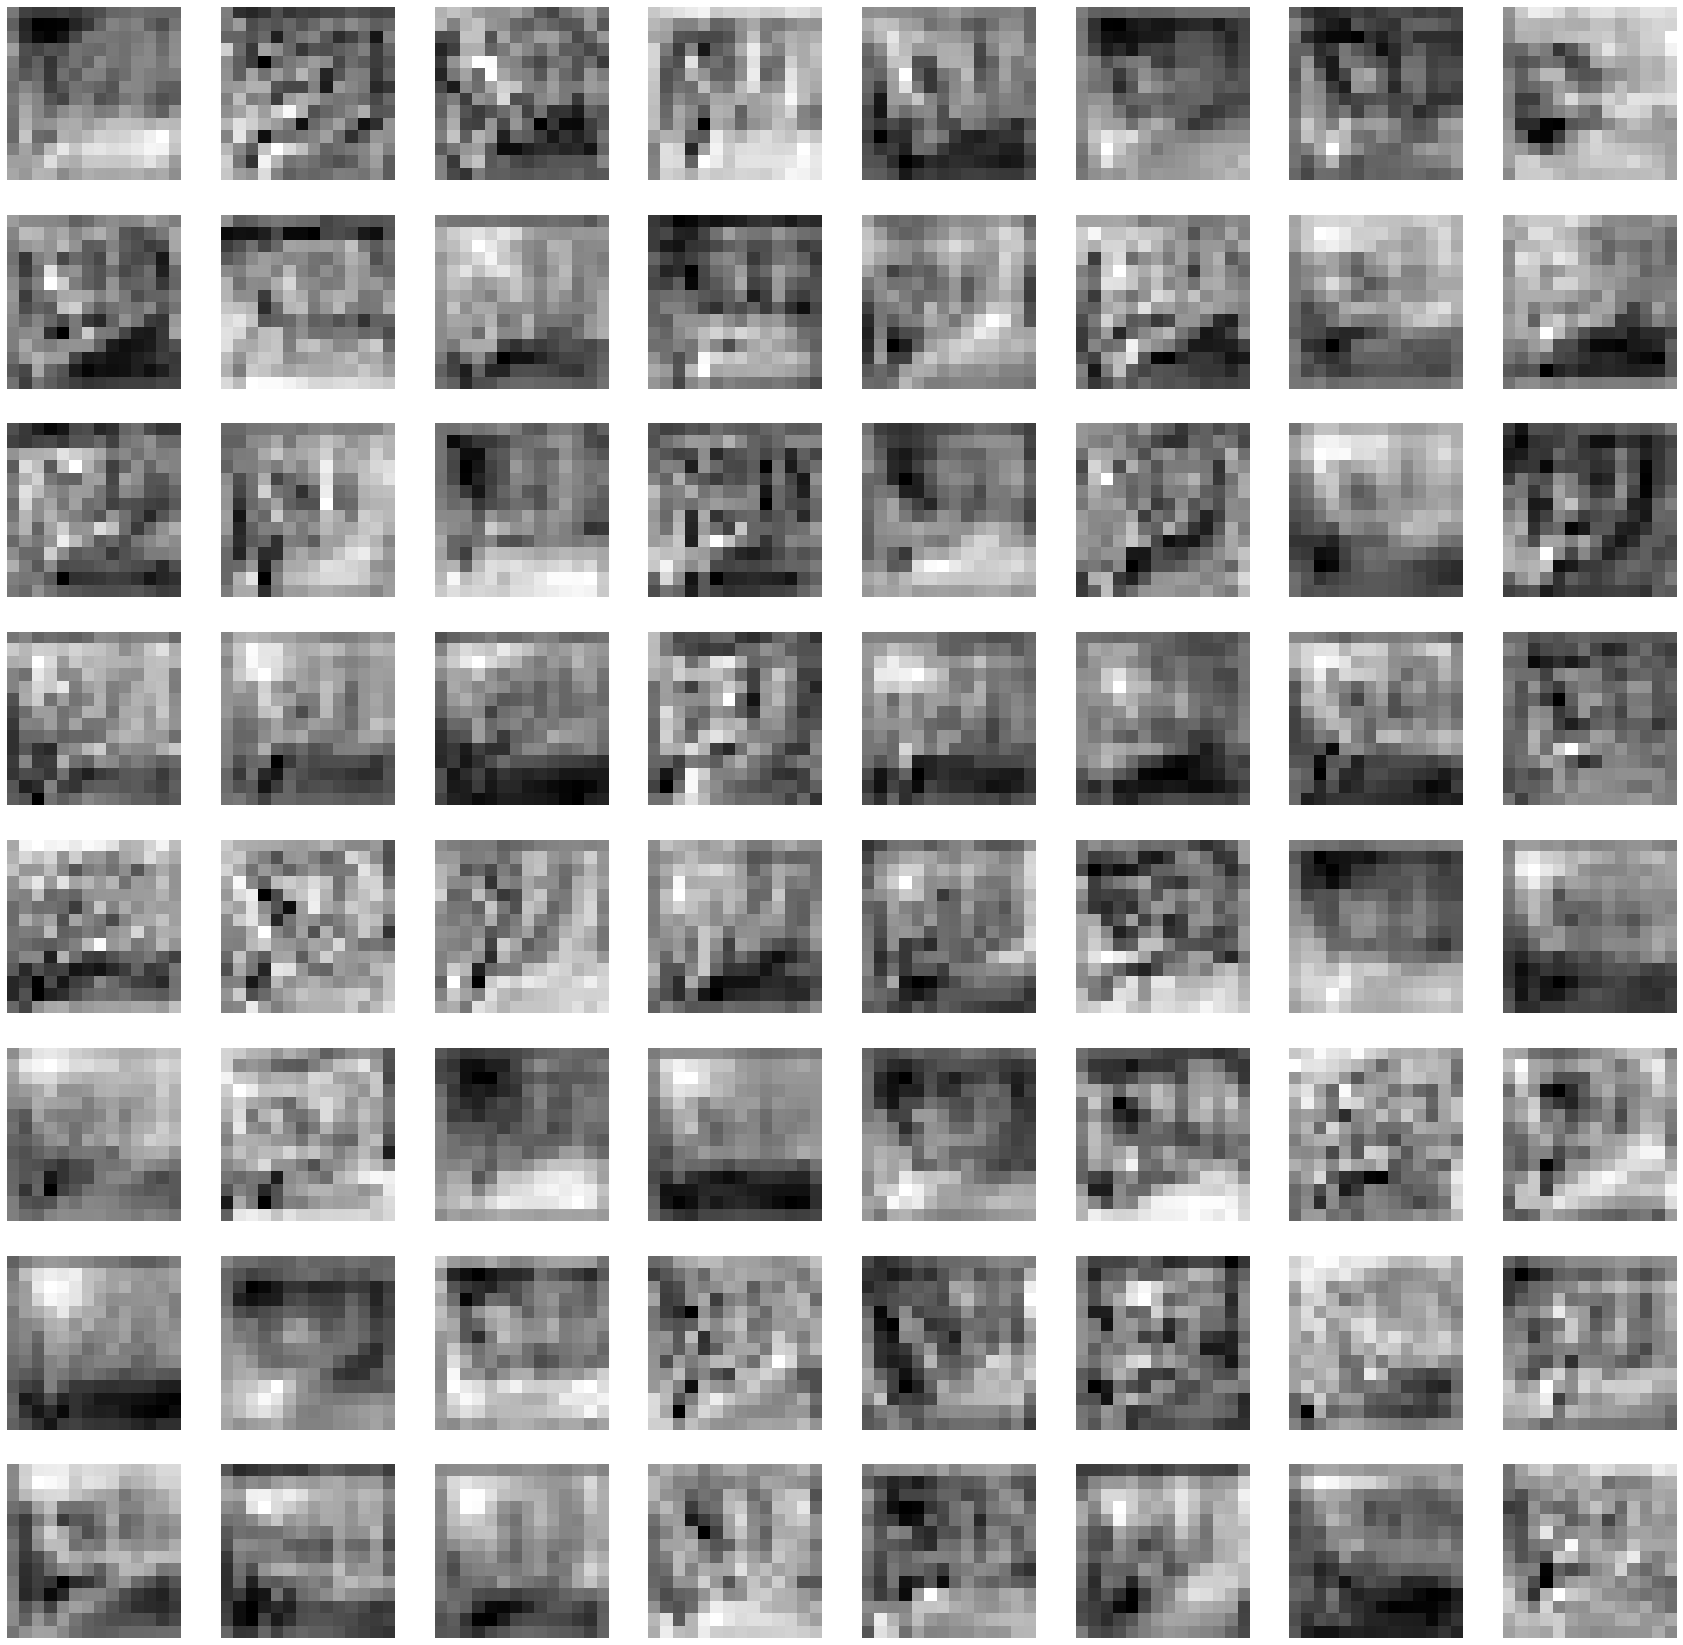

torch.Size([256, 14, 14])


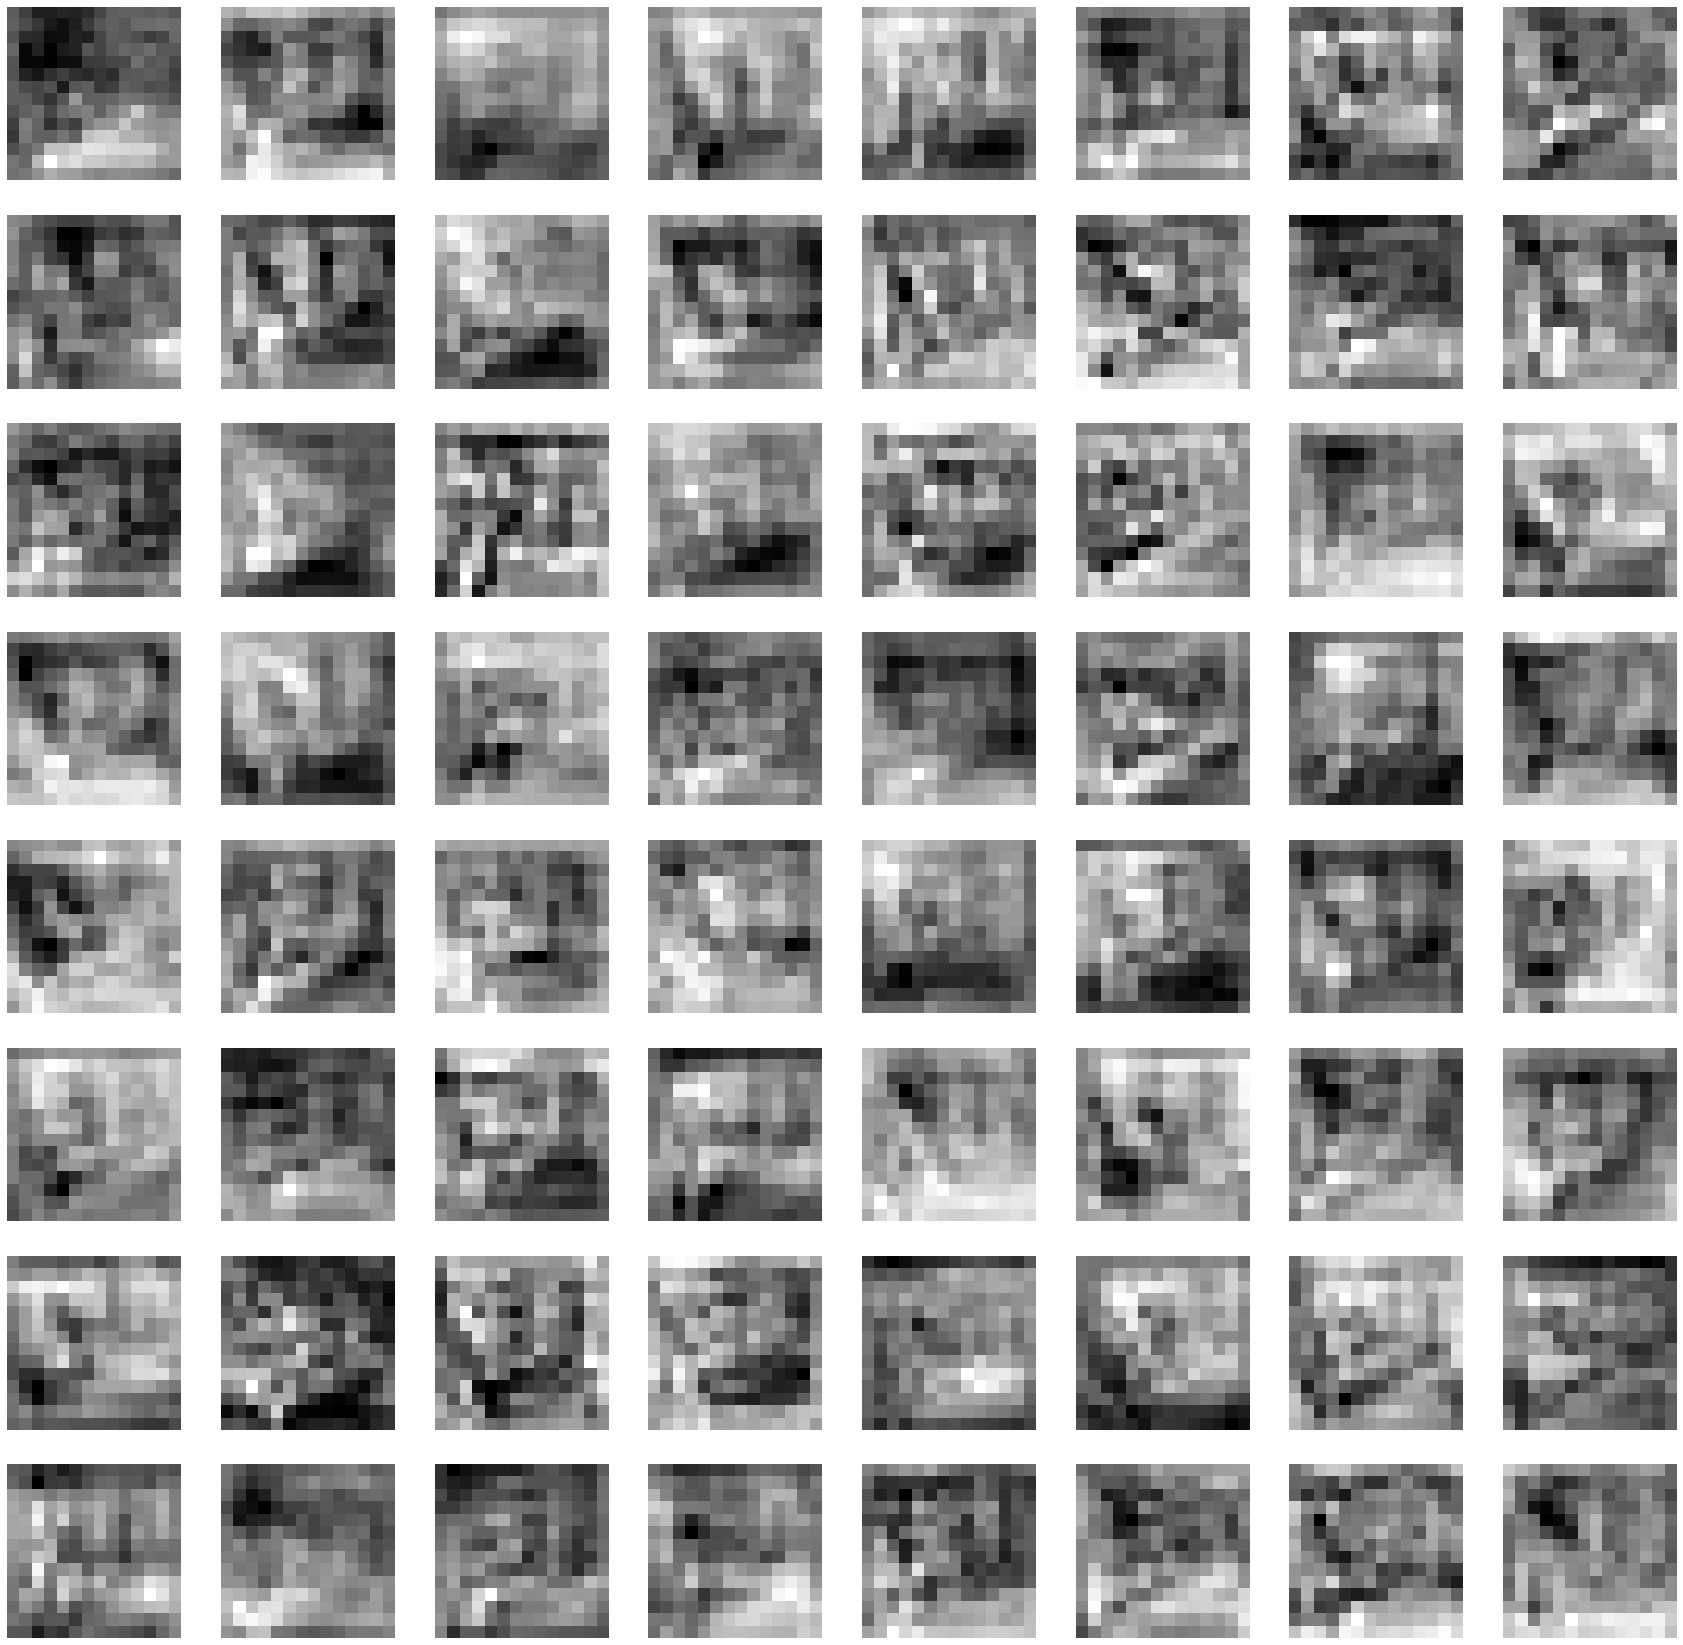

torch.Size([256, 14, 14])


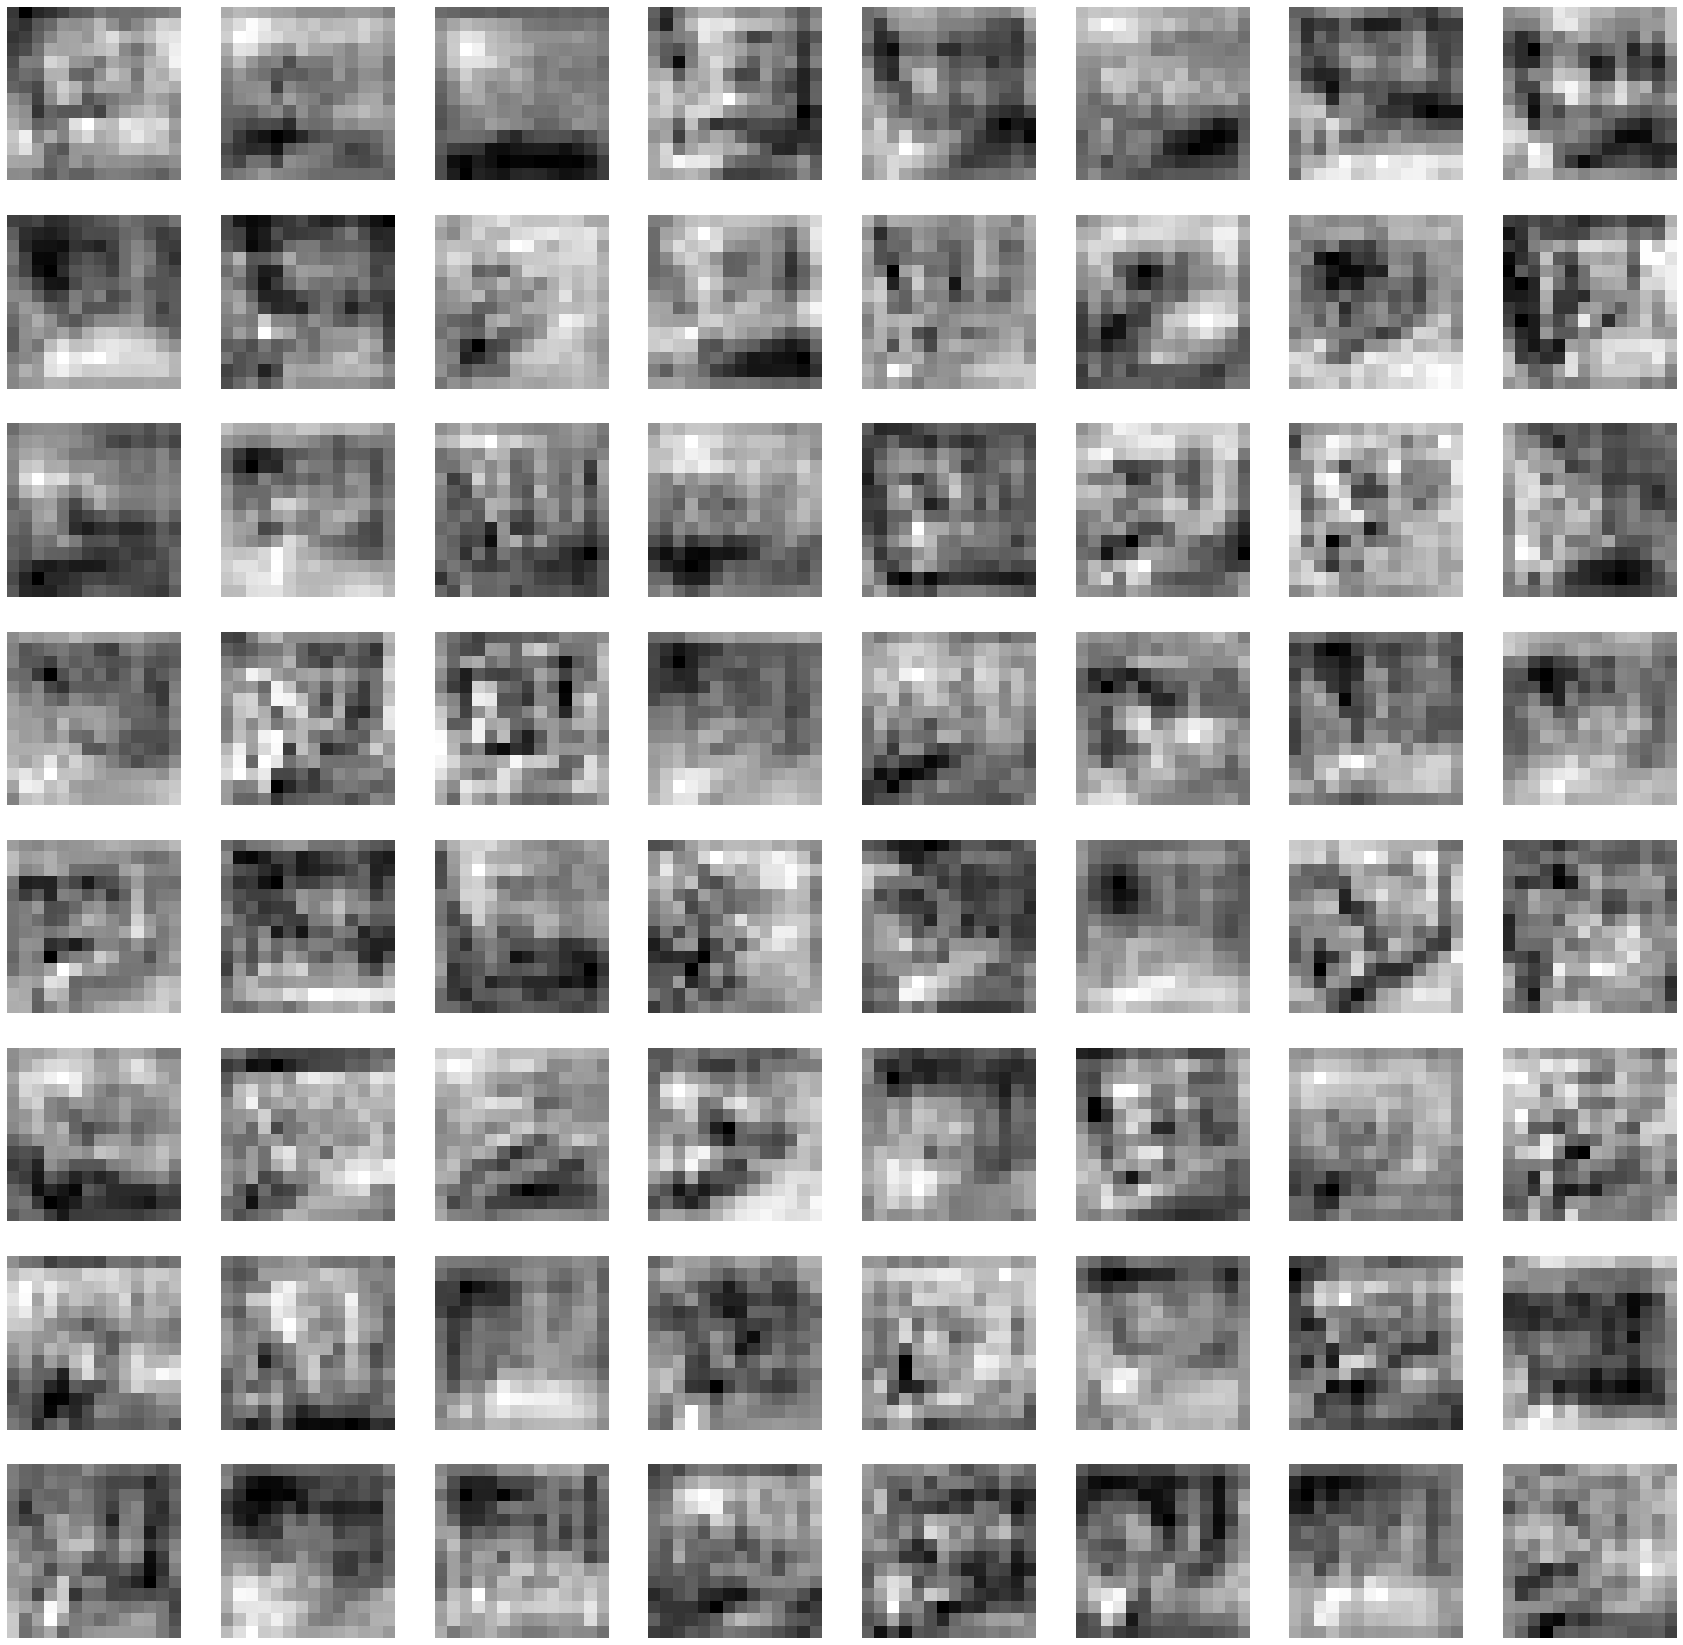

torch.Size([256, 14, 14])


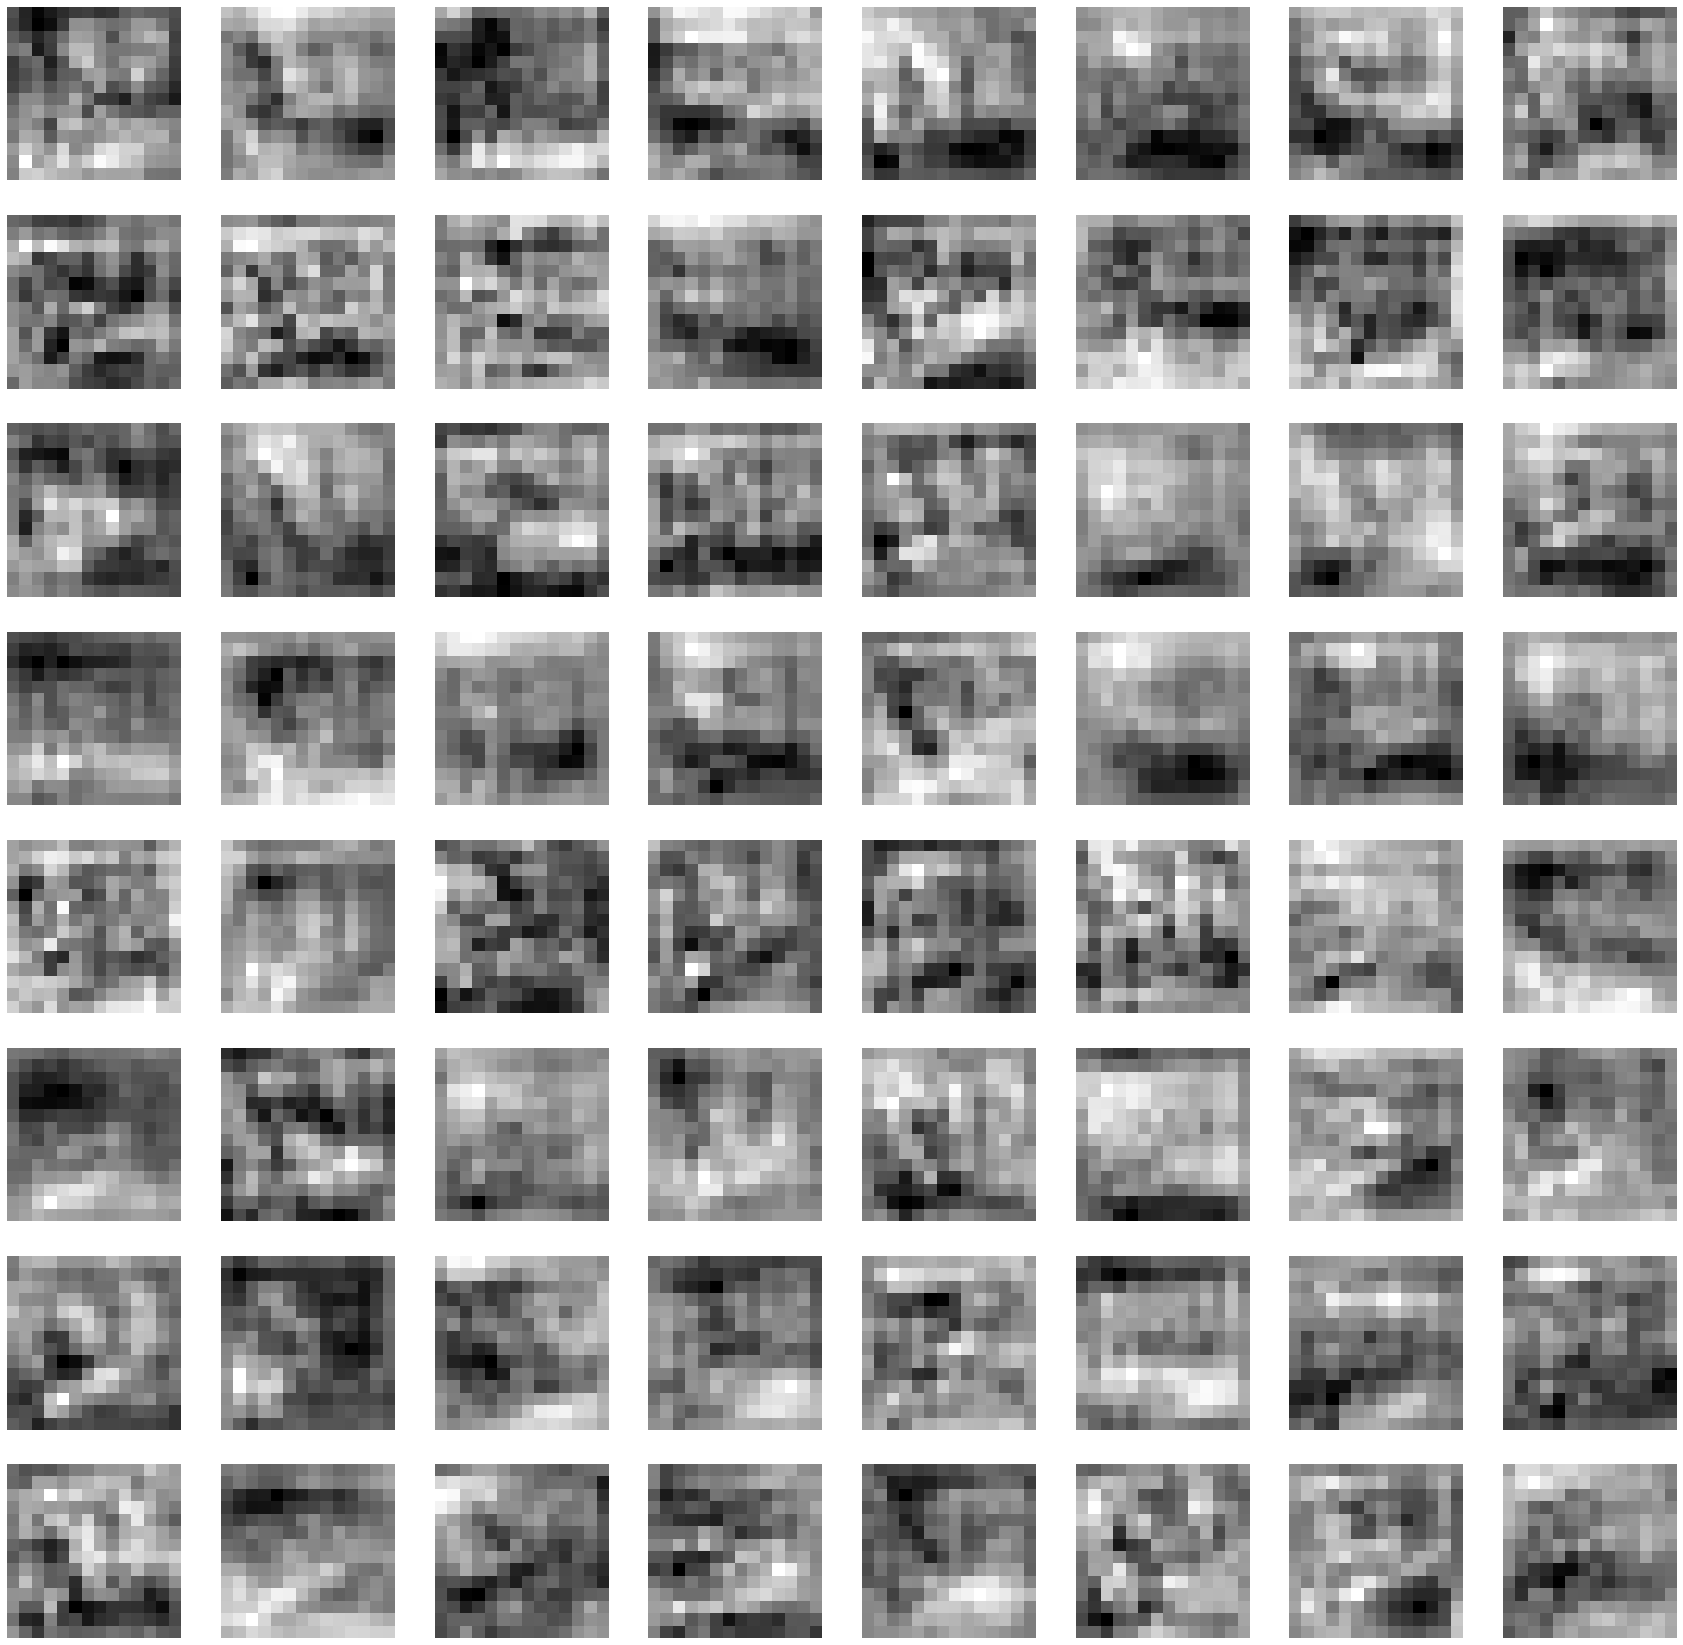

torch.Size([512, 7, 7])


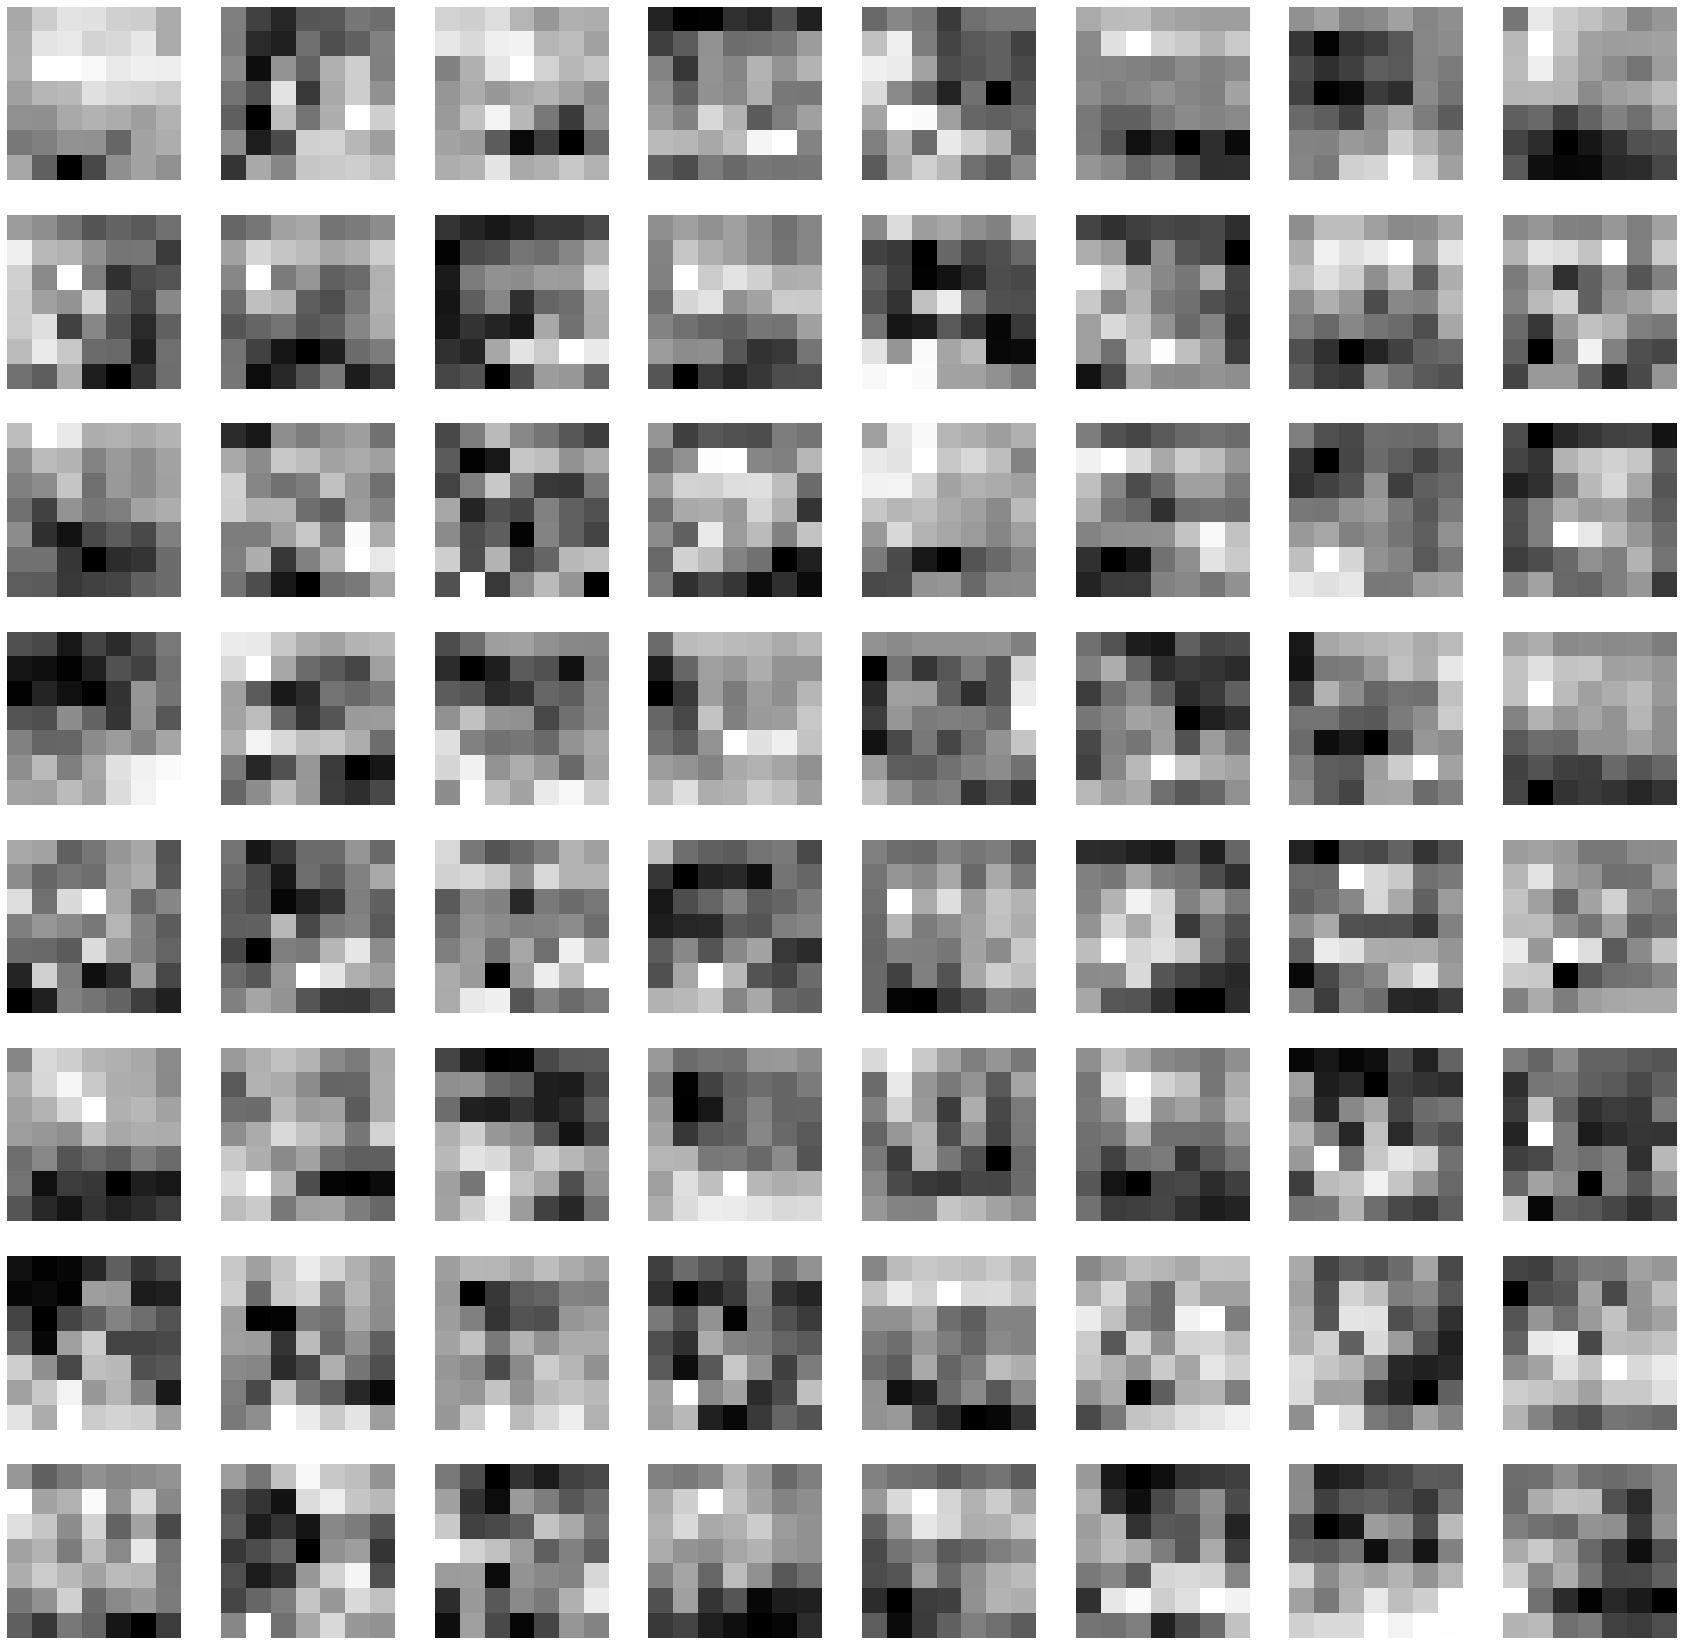

torch.Size([512, 7, 7])


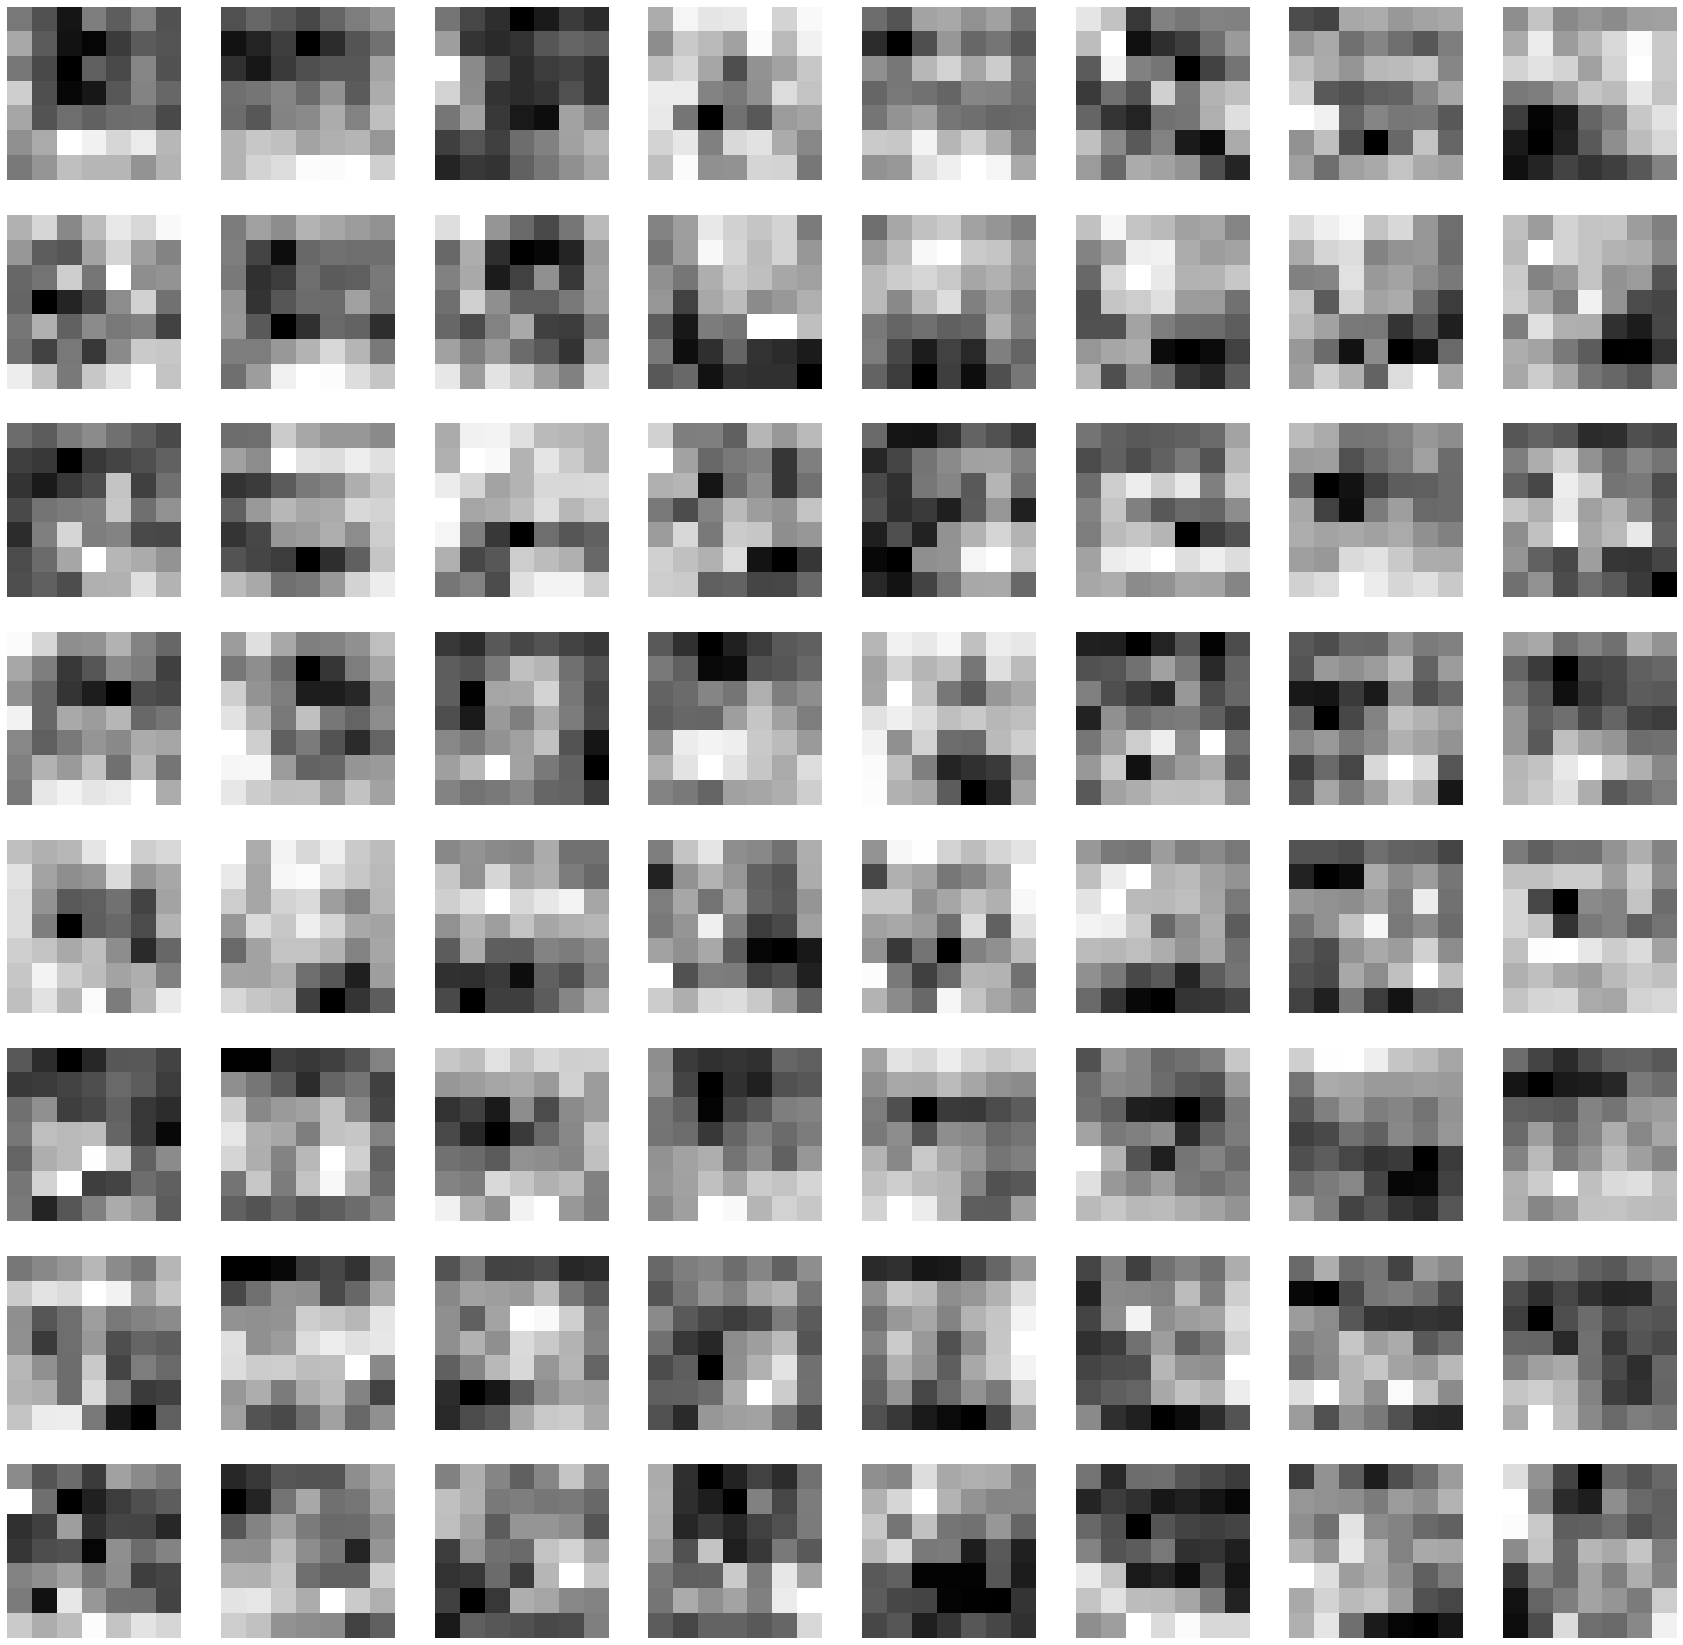

torch.Size([512, 7, 7])


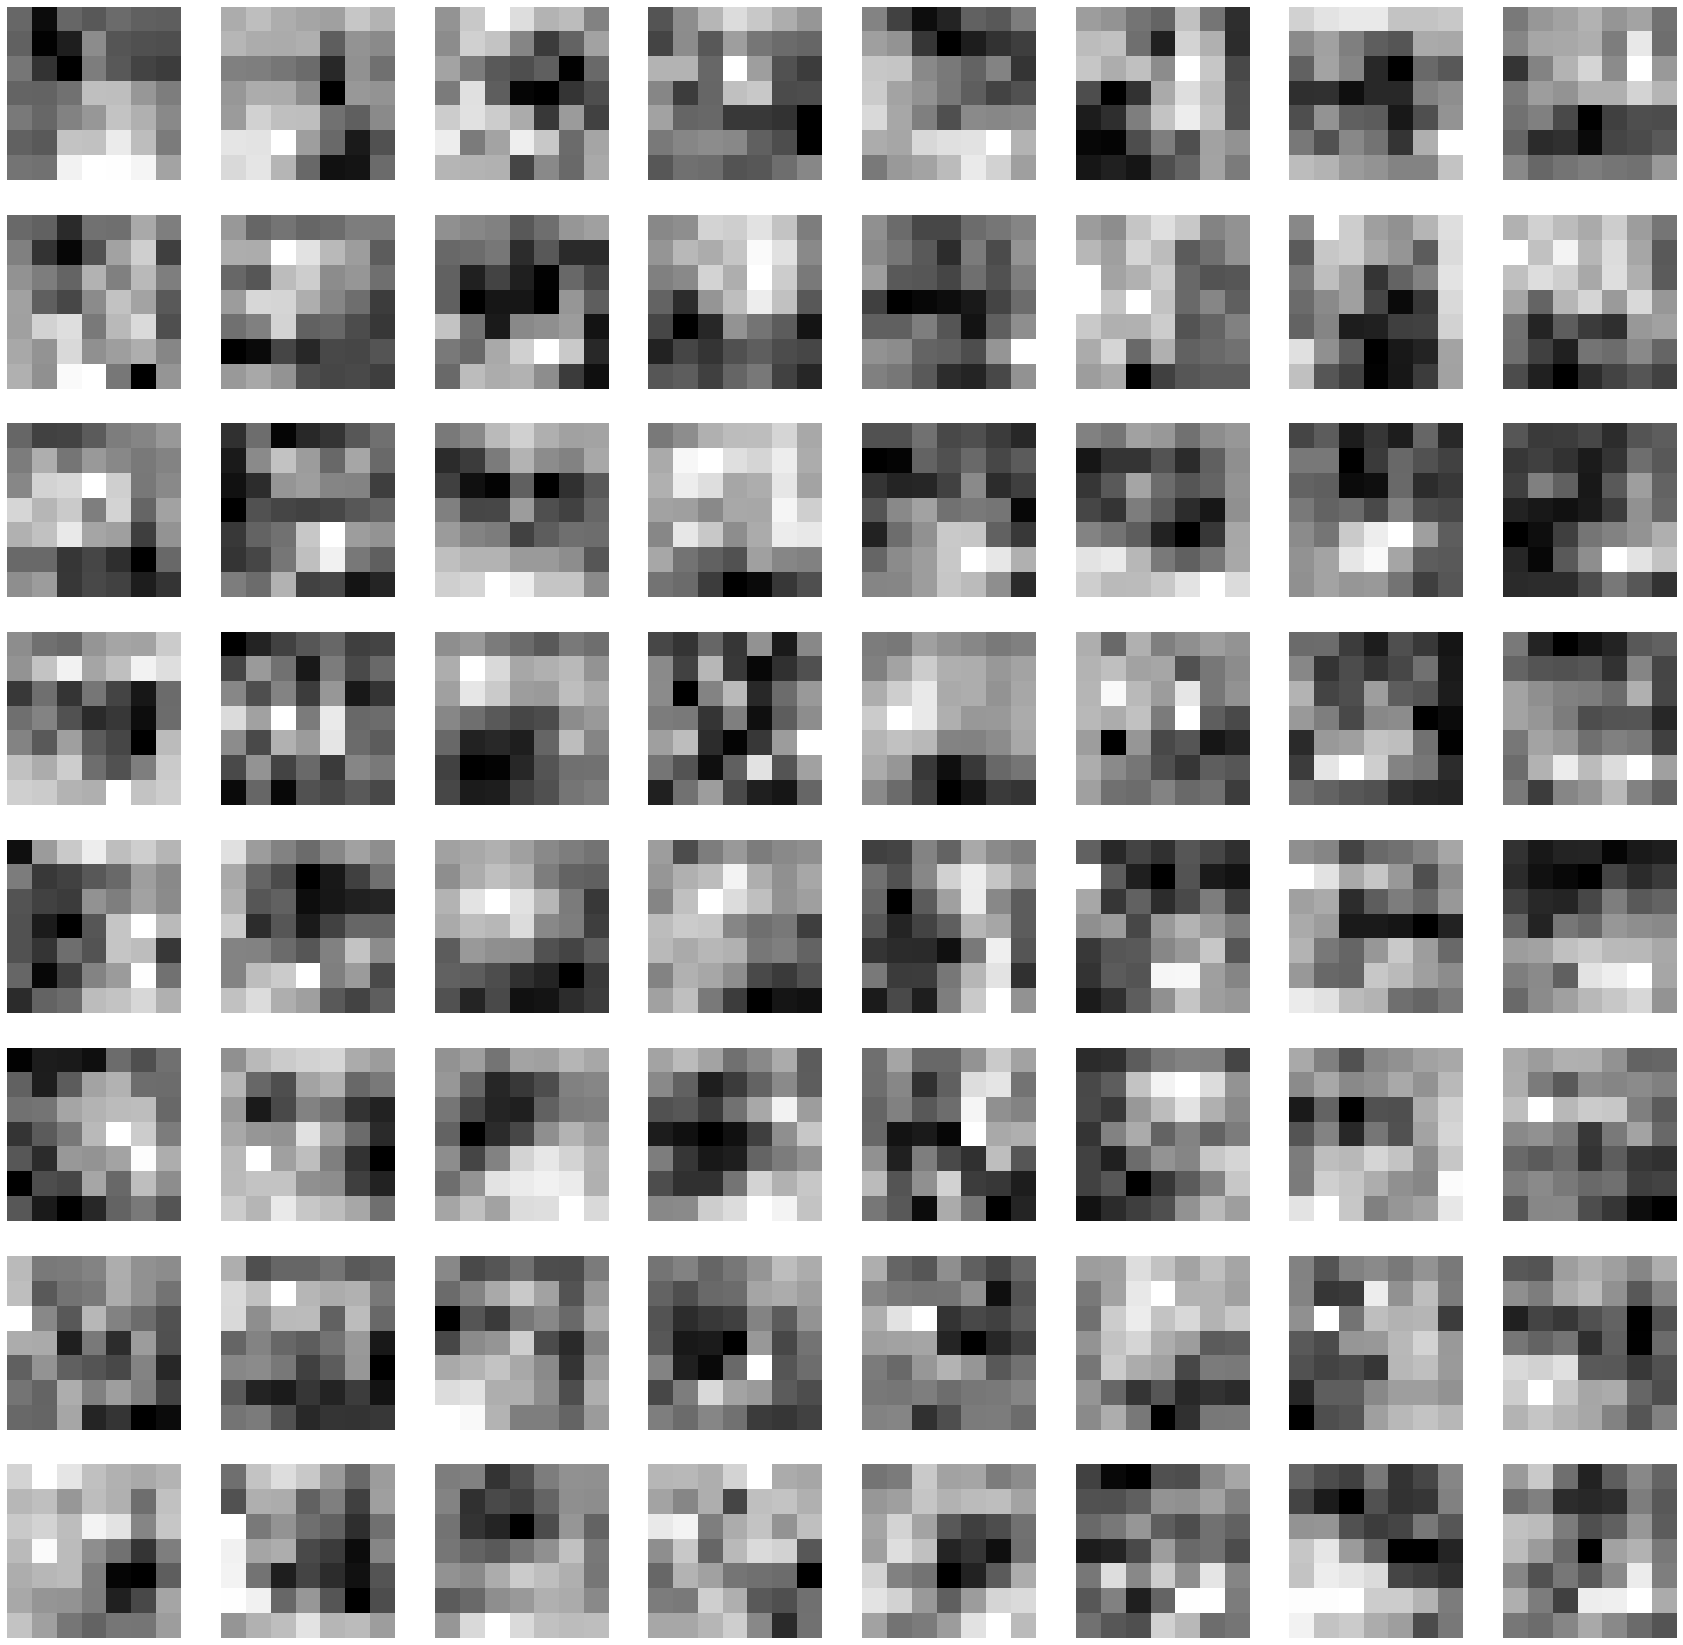

torch.Size([512, 7, 7])


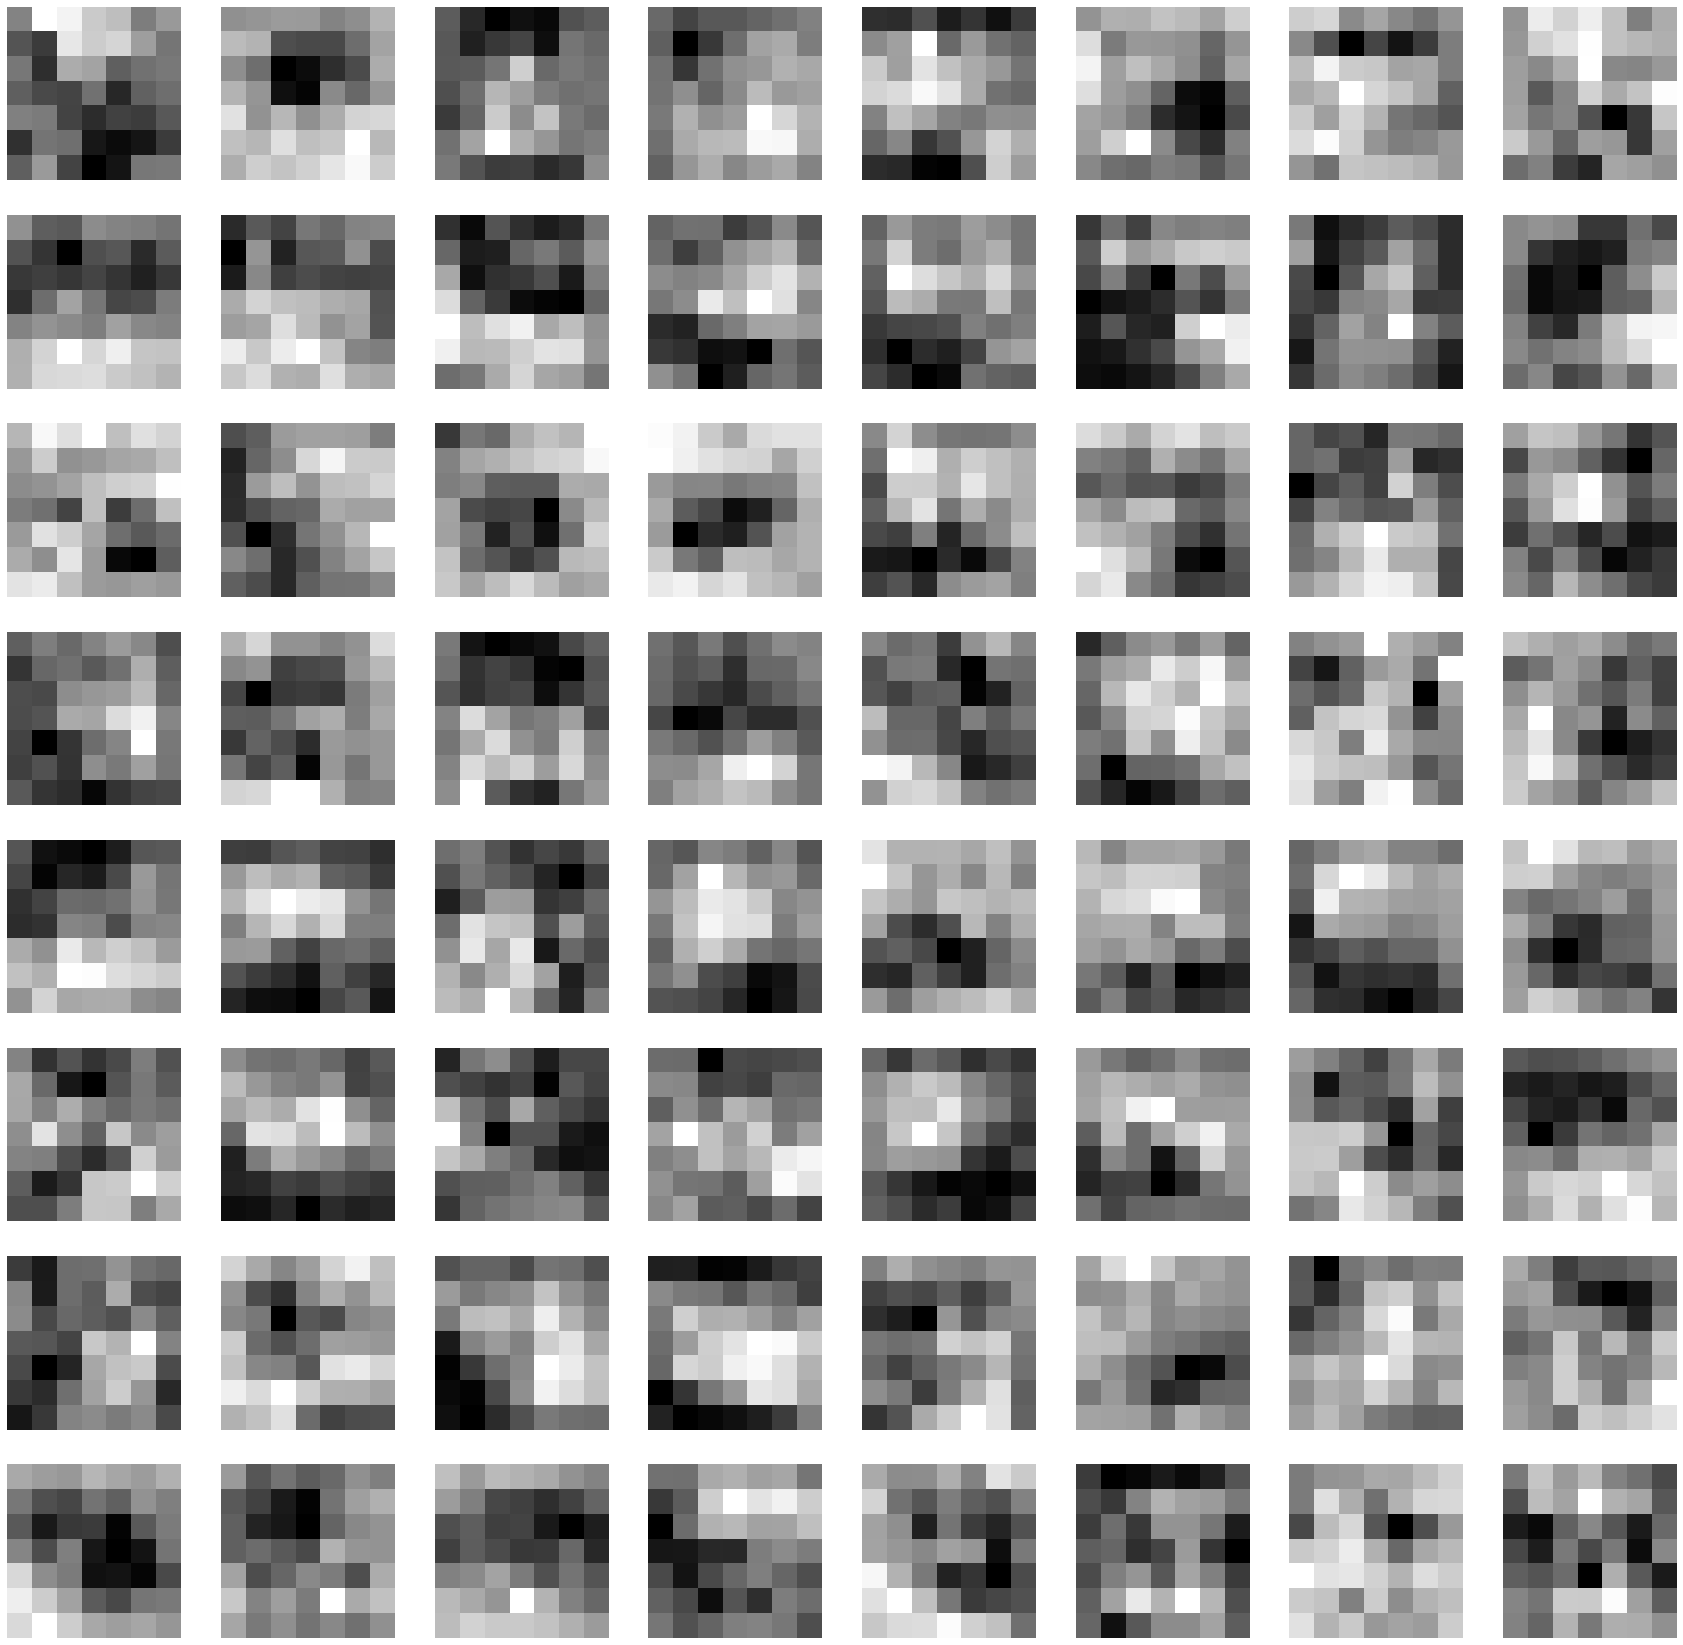

In [116]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    # print(f"Saving layer {num_layer} feature maps...")
    # plt.savefig(f"../outputs/layer_{num_layer}.png")
    plt.show()
    plt.close()